# Project Phase 2: Implementation

## Introduction:
In this phase of the project, you will be combining all the data generated by each member of
your group and train models to implement the system for authorship attribution (i.e. determining
which of the twitter users scraped by each member of your group are responsible for posting a
given tweet in the test set.

## Group 4: 
- Sumair Ijaz Hashmi - 24100004
- Shabbir Hussain - 24100240
- Naafey Aamer - 24100117
- Shafay Kashif - 24100160
- Syed Aaqib Rafie Hasanie - 24100223
- Wjeeh Ul Azeem - 24100006

## Importing Libraries

In [37]:
# importing all libraries
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier


In [ ]:
twitter_handles = ['joejonas', 'EASPORTSFIFA', 'LeoVaradkar', 'MLB', 'rustyrockets', 'BBCSport']

# Task 1: Feature Preparation

### Task 1.1: Bag of Word Features
Combine all the tweets scraped by each member, split the data using an appropriate split ratio
and build a collective unique_wordsulary and corresponding bag of word features using the functions
you implemented in phase 1. The idea then was to get you to write those functions to
understand how they work by demonstrating their usage within your own tweets, now you will be
using that implementation on the collective group data.

In [38]:
# add output class to tweet files
for handle in twitter_handles:
    df = pd.read_csv(f'./handles_data/{handle}.csv')
    label = [handle for i in range(len(df))]
    df['Twitter Handle'] = label
    df.to_csv(f'./handles_data/{handle}.csv', index=False)

In [39]:
# combine all tweets 
df = pd.concat([pd.read_csv(f'./handles_data/{handle}.csv') for handle in twitter_handles])
df = df.reset_index(drop=True)
df.to_csv('./all_tweets.csv', index = False)

In [40]:
df.head()

,Tweets,Twitter Handle
0,starting season right,joejonas
1,latest issue alexa great time chatting style h...,joejonas
2,thank,joejonas
3,almost ready dallas,joejonas
4,love good debate right full video youtube,joejonas


In [41]:
df.head()

,Tweets,Twitter Handle
0,starting season right,joejonas
1,latest issue alexa great time chatting style h...,joejonas
2,thank,joejonas
3,almost ready dallas,joejonas
4,love good debate right full video youtube,joejonas


In [42]:
# split train test 
train, test = train_test_split(df, test_size = 0.2, shuffle=True)

In [43]:
train.head()

,Tweets,Twitter Handle
2254,good article new digital gaming tax credit wor...,LeoVaradkar
4473,arbzeh brilliant freyabettsart shes amazing,rustyrockets
1715,goal secures second trophy,EASPORTSFIFA
3194,game 1 electric game 2 worldseries,MLB
167,last night,joejonas


In [44]:
def create_vocabulary(X_train):
    allvocab = []
    for ind in X_train.index:
        tweet = X_train['Tweets'][ind].split(" ")
        for j in range(len(tweet)):
            allvocab.append(tweet[j])

    unique_words = list(set(allvocab))

    return allvocab, unique_words

allvocab, unique_words = create_vocabulary(train)


In [45]:
# create bag of words
def create_bags(unique_words, train):
    X_complete = []
    all_dicts = []
    # laplace smoothing
    arr = [1] * len(unique_words)

    for ind in train.index:
        cleaned_dict = dict(zip(unique_words, arr))
        all_dicts.append(cleaned_dict)
    print(len(all_dicts), len(all_dicts[0]))
    j = 0
    for ind in train.index:
        cleaned = train['Tweets'][ind].split(" ")
        for i in range(len(cleaned)):
            if cleaned[i] in unique_words:
                all_dicts[j][cleaned[i]] += 1
            # get values
        bag_of_words = list(all_dicts[j].values())
        X_complete.append(bag_of_words)
        j += 1        

    return X_complete 

X_complete_train = create_bags(unique_words, train)
train["BOWs"] = X_complete_train

X_complete_test = create_bags(unique_words, test)
test["BOWs"] = X_complete_test


4544 9952
1137 9952


In [47]:
train.to_csv("./train_data.csv", index=False)
test.to_csv("./test_data.csv", index=False)

### Task 1.2: Embeddings
In order to familiarize you with the current state-of-the-art method of text representation, in this
part you will be using embeddings to get your features. The advantage of using this over
features based on pure counts is the inclusion of context and semantic information which means
that your features code richer information and can therefore lead to models performing better
given that they provide a higher quality input. These embeddings are obtained using transformer
models, you can read more about transformers here. To understand sentence embeddings
better, you can refer to this article.
For the purpose of this task, you will be using BERT Sentence Embeddings. The specific
transformer model is “all-MiniLM-L6-v2”. Use this to first encode your tweets and get the
representations for your dataset and then split these into train and test sets using an appropriate
split ratio.

In [48]:


model = SentenceTransformer("all-MiniLM-L6-v2")
df_train = pd.read_csv("./train_data.csv")
tweets = df_train["Tweets"].to_numpy()
embeddings = model.encode(tweets)
df_train["embeddings"] = [None] * len(df_train)
i = 0
for ind in df_train.index:
    df_train["embeddings"][ind] = embeddings[i]
    i+=1 


In [49]:
df_test = pd.read_csv("./test_data.csv")
tweets = df_test["Tweets"].to_numpy()
embeddings = model.encode(tweets)
df_test["embeddings"] = [None] * len(df_test)
i = 0
for ind in df_test.index:
    df_test["embeddings"][ind] = embeddings[i]
    i+=1 

In [50]:
df_train.to_csv("./train_embeddings_data.csv", index=False)
df_test.to_csv("./test_embeddings_data.csv", index=False)

### Task 2: KNNs
Now that your features are all set and ready to go, use Sickit Learn’s KNN model to get predictions for authorship attribution.
Do 5-fold cross-validation and report the validation and training losses using graphs. Use scikit-learn’s accuracy_score function to calculate the accuracy, classification_report to calculate
macro-average (precision, recall, and F1), and confusion_matrix function to calculate confusion matrix on the test set.
Do this for both types of features separately

#### BOW features

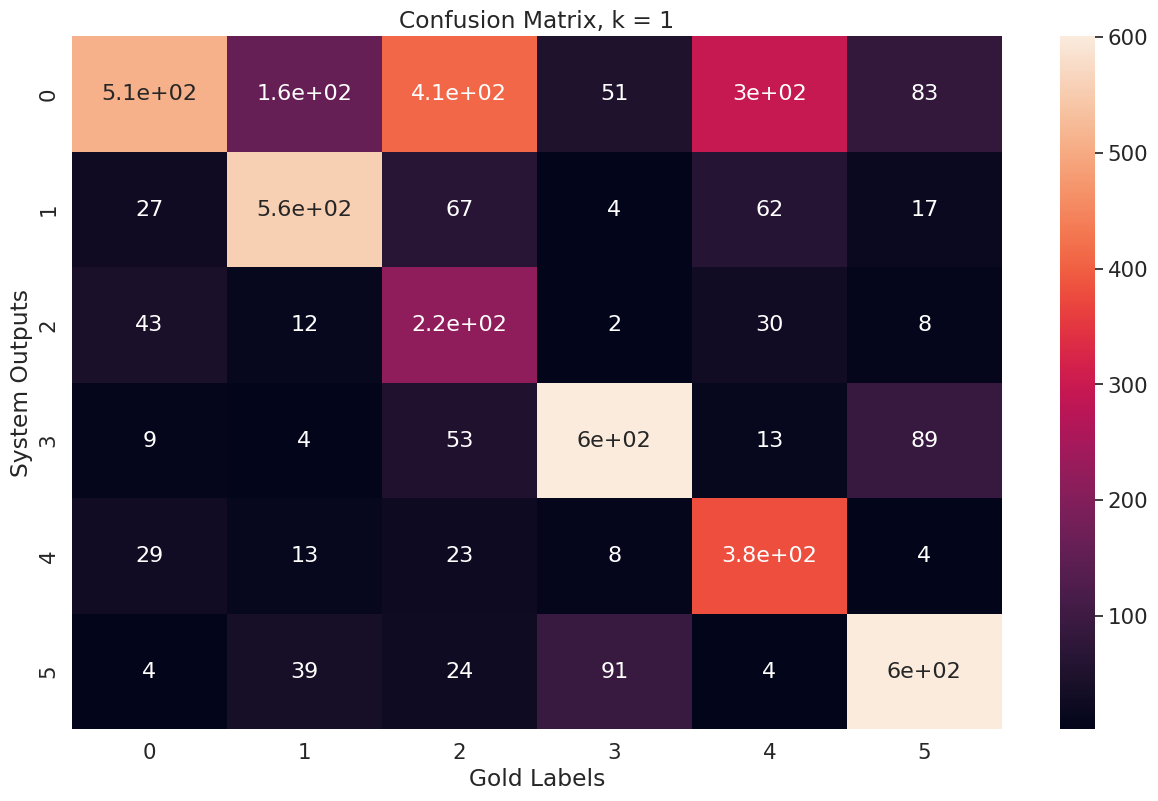

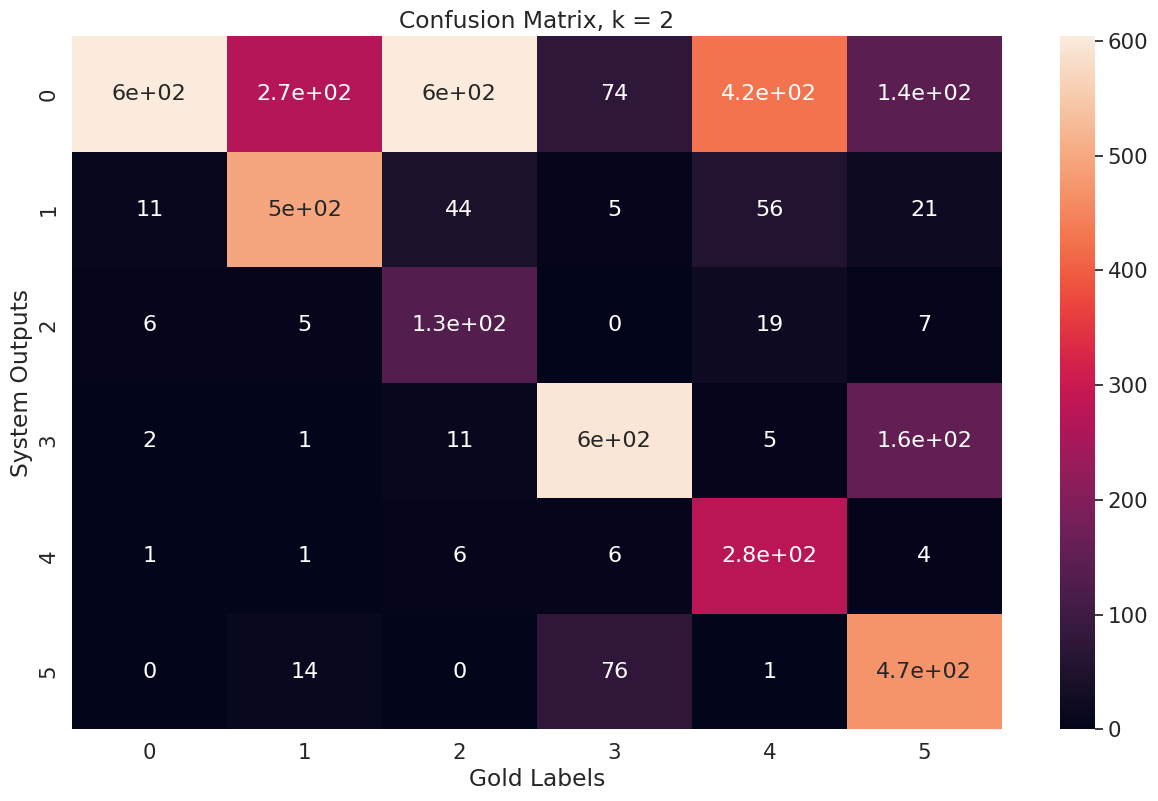

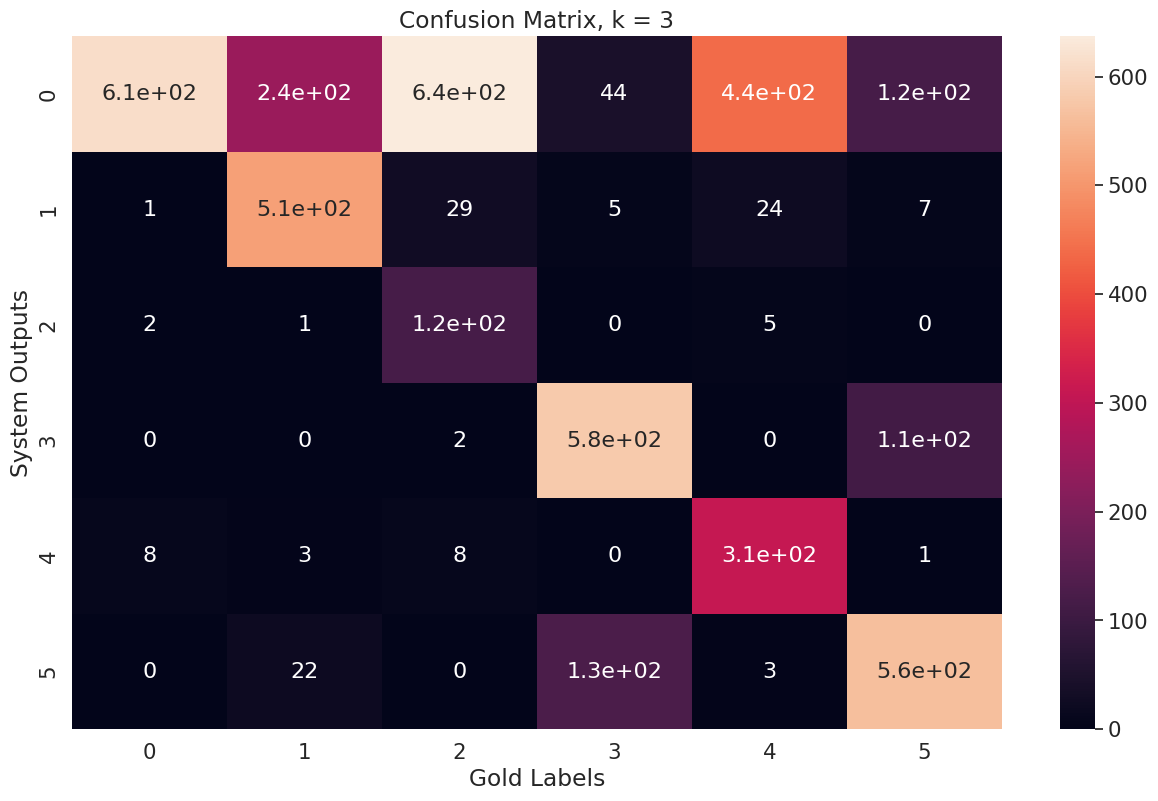

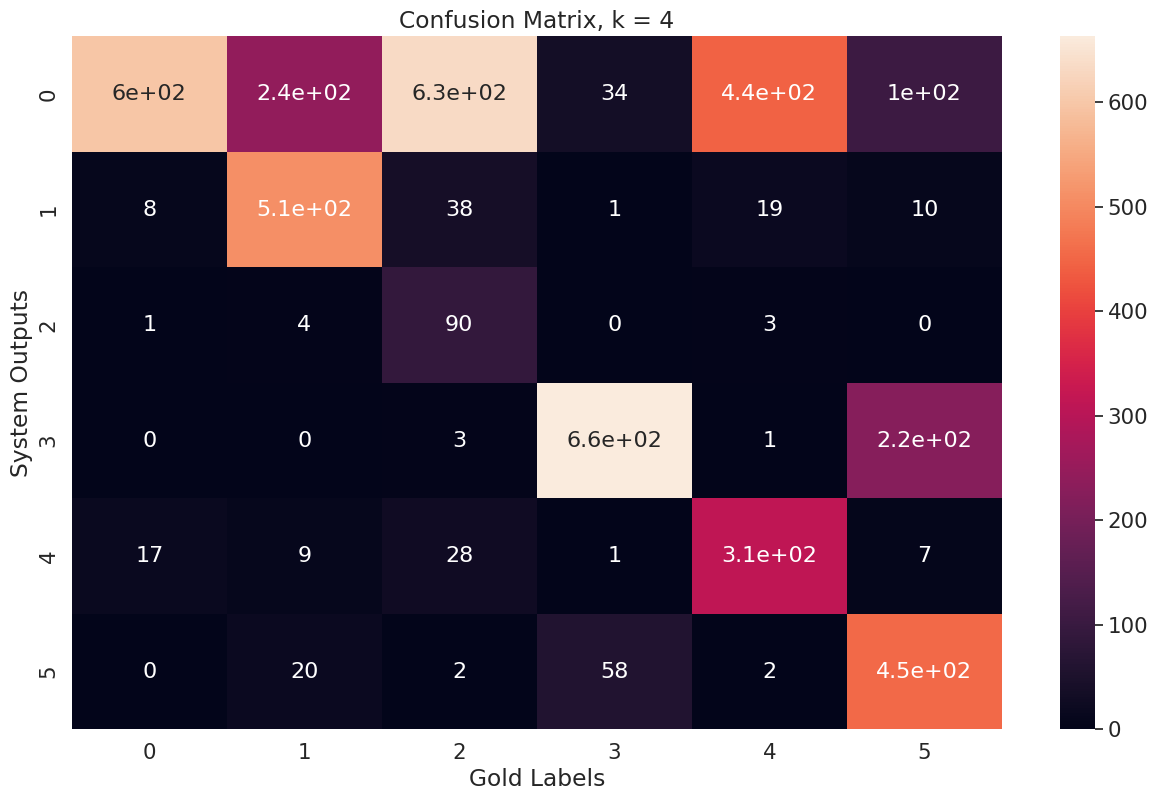

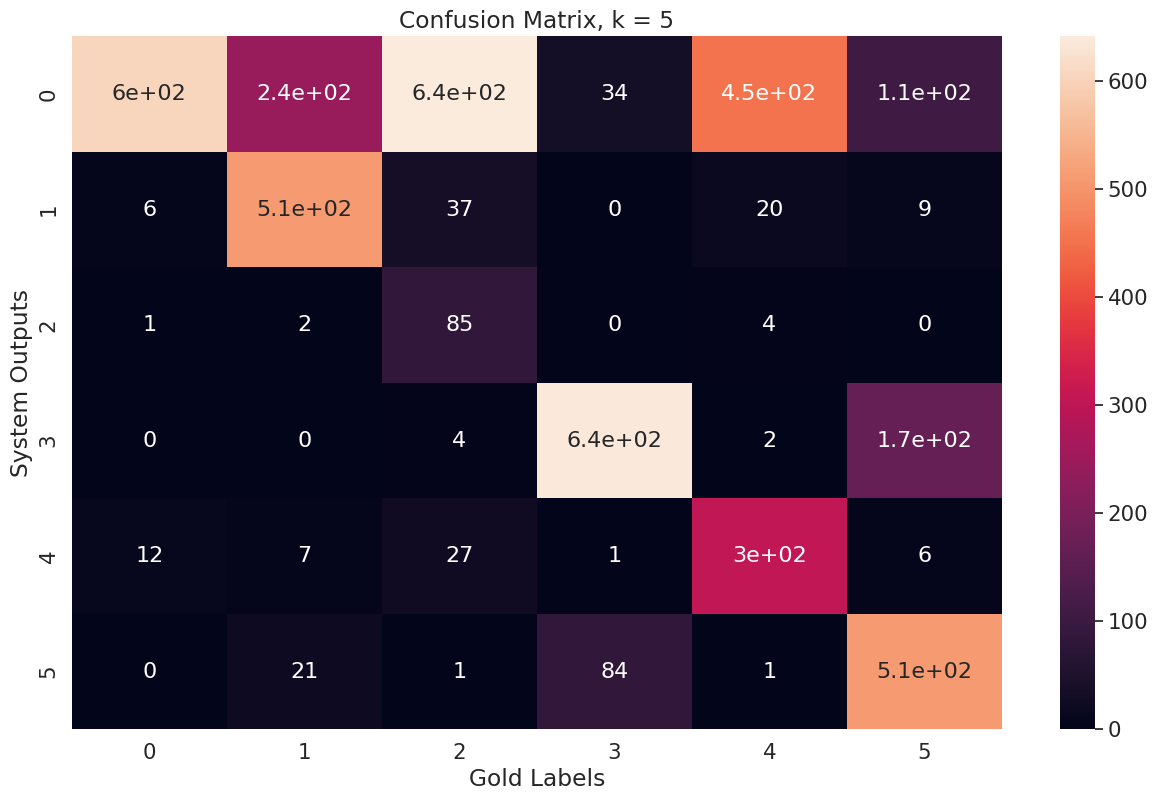

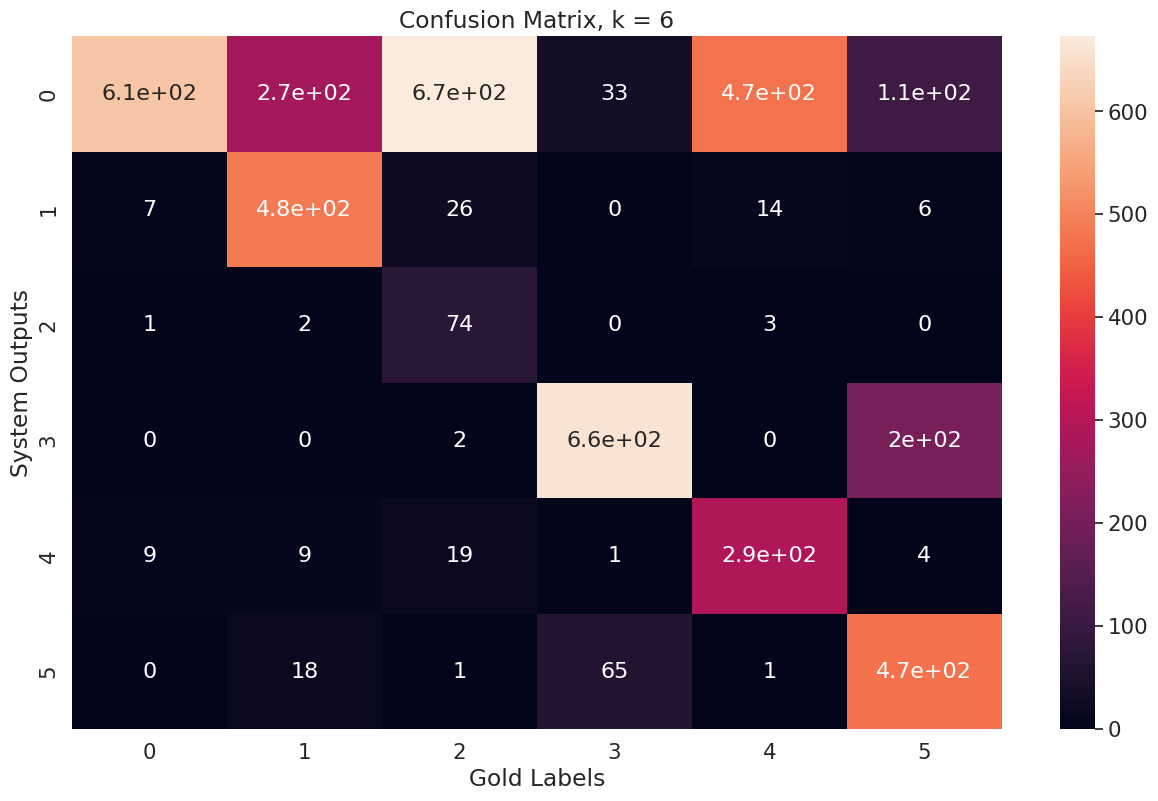

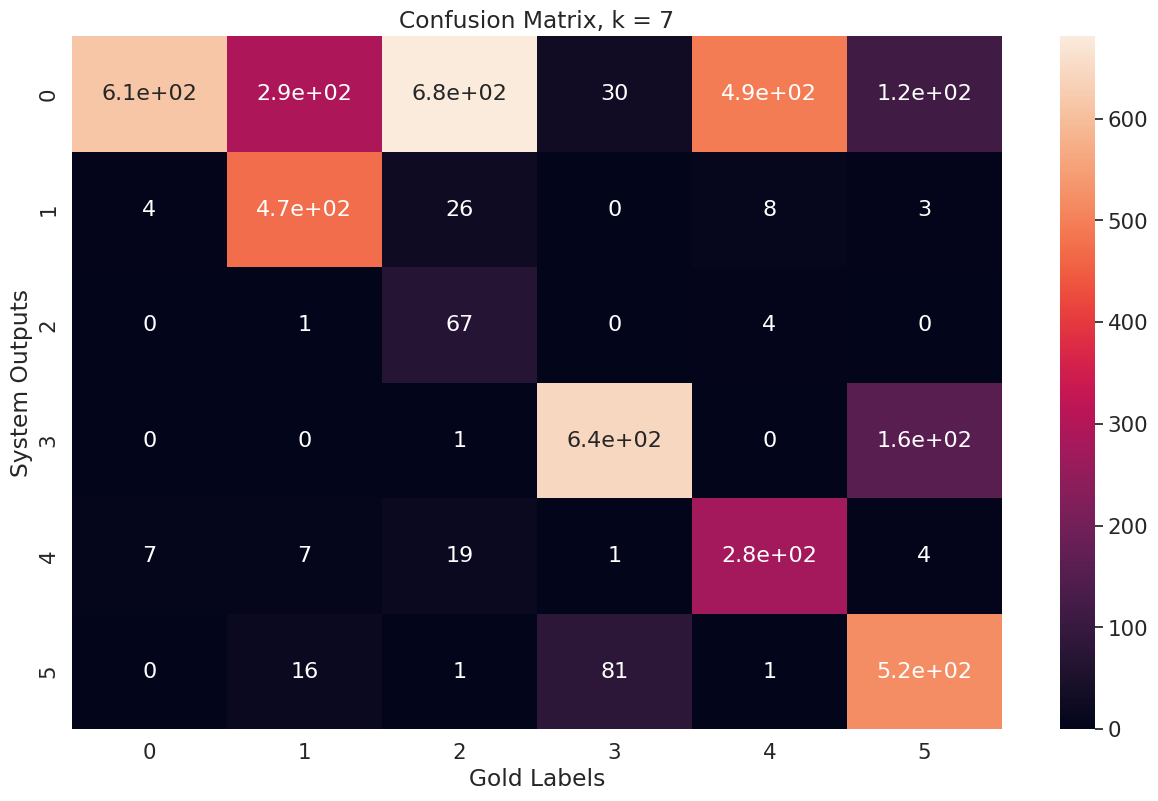

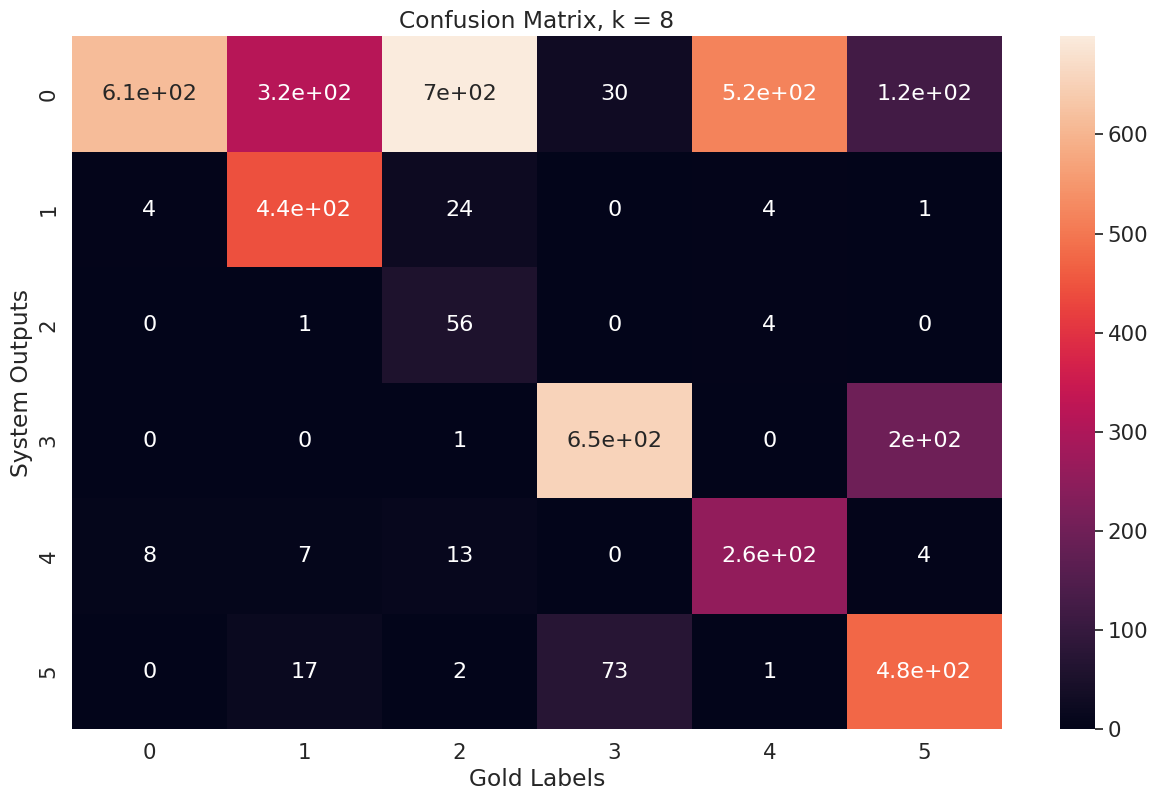

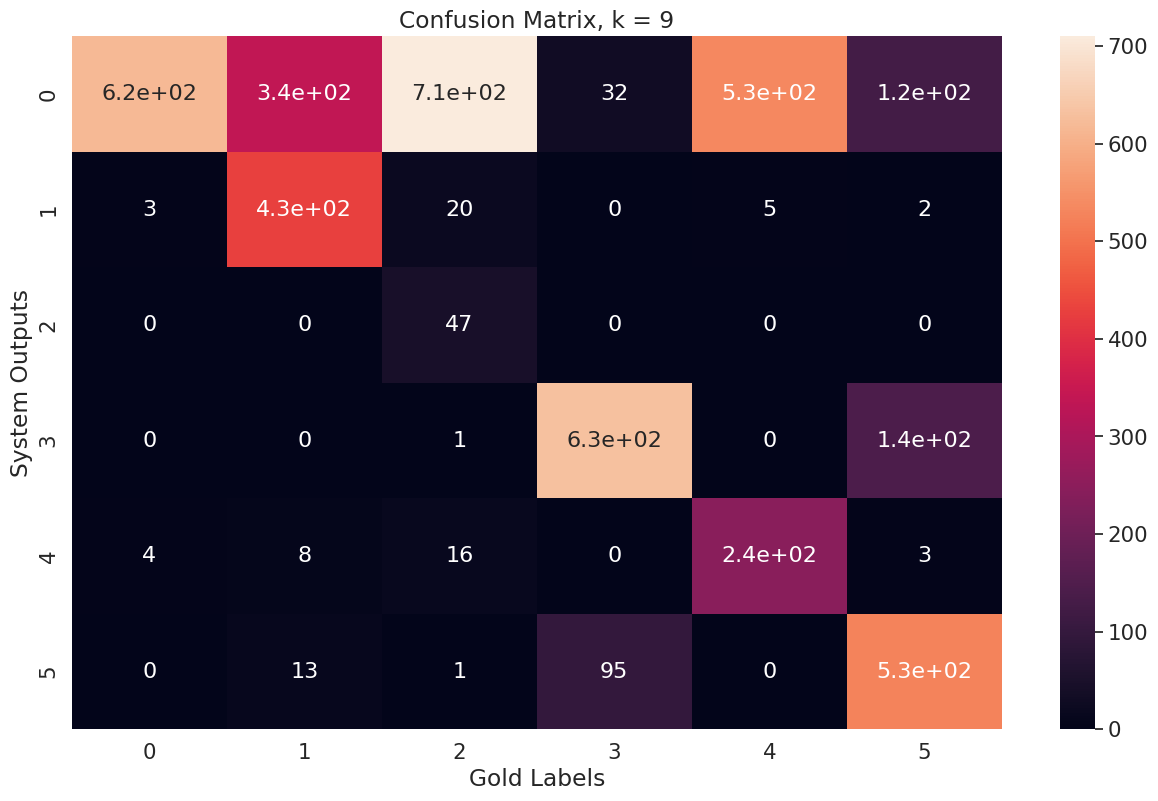

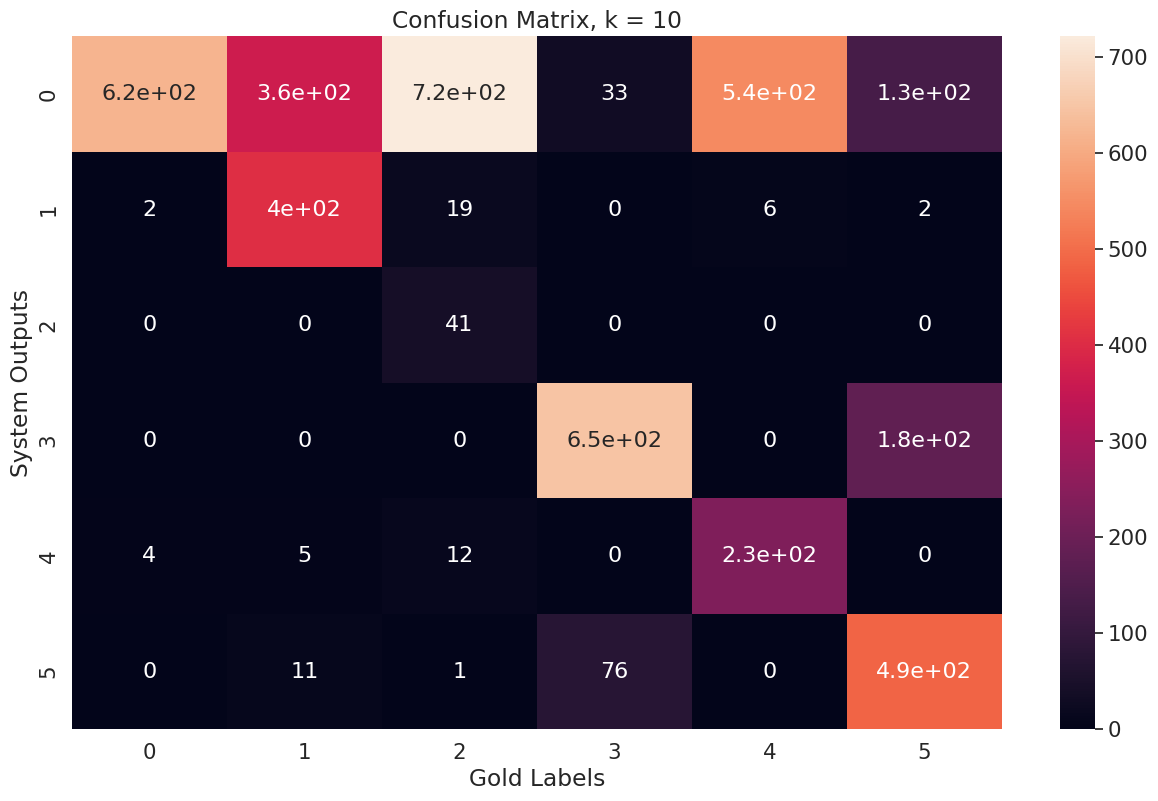

In [52]:
train = pd.read_csv("./train_data.csv")
train_features = train["BOWs"]
train_labels = train["Twitter Handle"]
num_arr = [0, 1, 2, 3, 4, 5]
numeric_labels_dict = dict(zip(twitter_handles, num_arr))
m = 5
numClasses = 6 
accuracies = []
f1s = []

def make_numeric_labels(train_labels, numeric_labels_dict):
    result = []
    for ind in train_labels.index:
        result.append(numeric_labels_dict[train_labels[ind]])
    return result

def make_numeric_features(train_features):
    result = []
    for ind in train_features.index:
        features = train_features[ind].split()
        features[0] = features[0].replace("[", "")
        features[-1] = features[-1].replace("]", "")
        for i in range(len(features)):
            features[i] = features[i].replace(",", "")
            features[i] = int(features[i])
        result.append(features) 
    return result       

# training and cross-validation

train_Y = make_numeric_labels(train_labels, numeric_labels_dict)
train_X = make_numeric_features(train_features)

validation_losses = []
training_losses = []

for k in range(1, 11):
    preds = np.zeros(0)
    knn = KNeighborsClassifier(n_neighbors = k, metric='euclidean')
    preds = cross_val_predict(knn, train_X, train_Y, cv = m)
    accuracy = accuracy_score(train_Y, preds)
    accuracies = np.append(accuracies, accuracy)
    report = classification_report(train_Y, preds, output_dict = True)
    f1 = report["macro avg"]["f1-score"]
    f1s = np.append(f1s, f1)
    confusionMatrix = confusion_matrix(preds, train_Y)
    cm = pd.DataFrame(confusionMatrix, range(0, numClasses), range(0, numClasses))
    plt.figure(figsize=(15,9))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True,annot_kws={"size": 16})
    plt.xlabel("Gold Labels")
    plt.ylabel("System Outputs")
    plt.title("Confusion Matrix, k = " + str(k))
    plt.show()
    knn.fit(train_X, train_Y)
    train_loss = 1 - knn.score(train_X, train_Y)
    training_losses.append(train_loss)
    val_loss = 1 - np.mean(cross_val_score(knn, train_X, train_Y, cv=5))
    validation_losses.append(val_loss)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


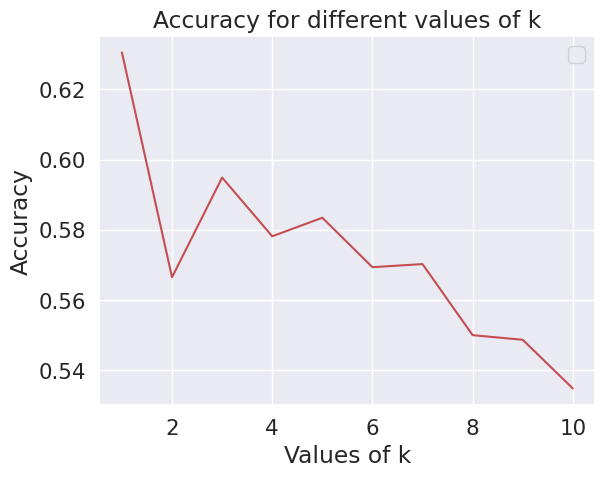

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


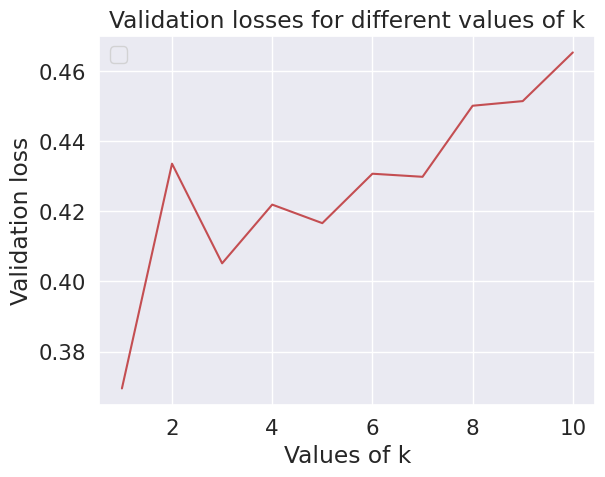

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


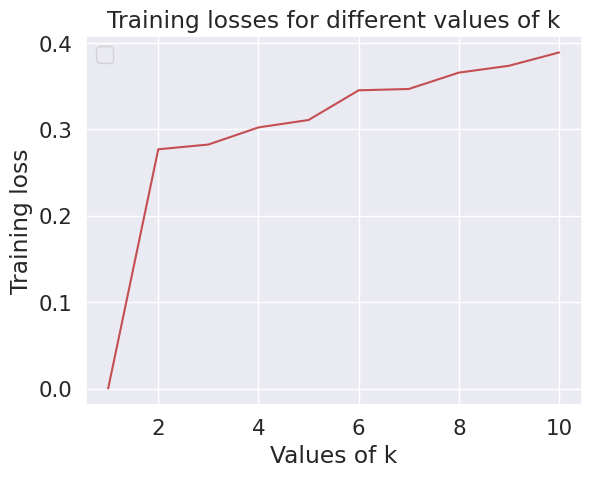

Best Value of k:  1


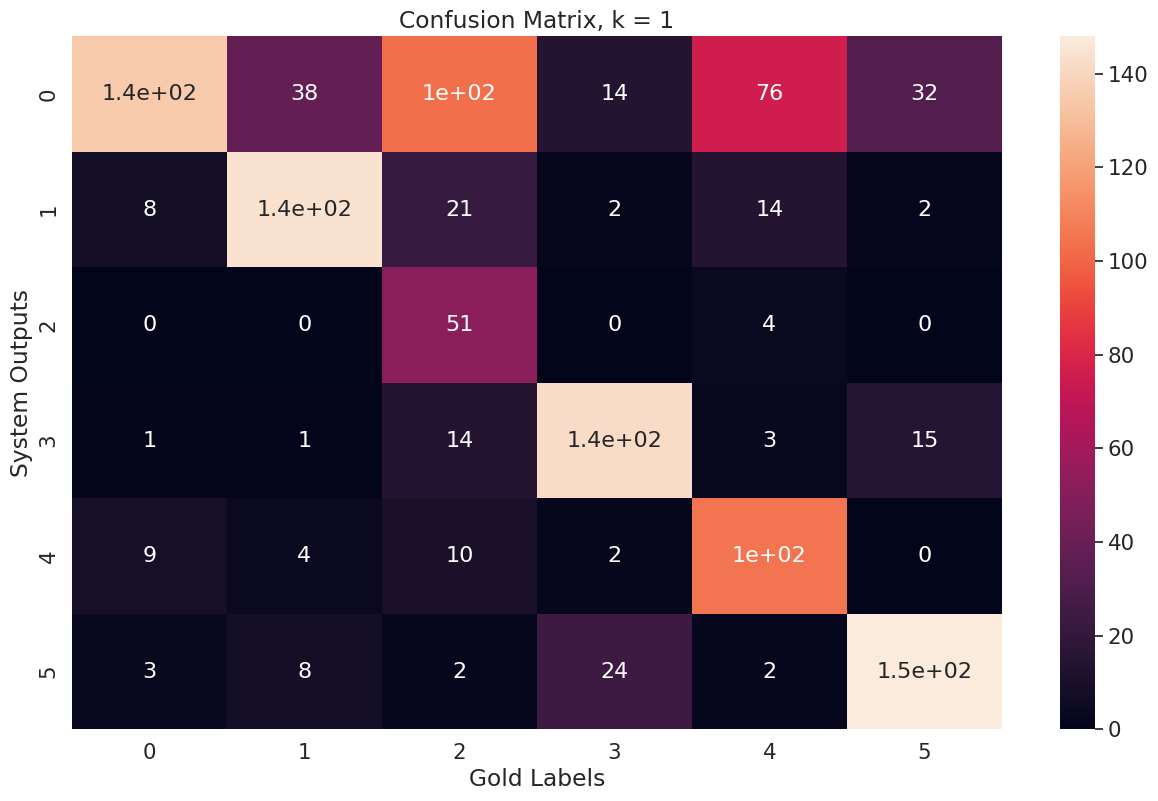

Classification Accuracy:  0.6376429199648197
Macro-Average F1:  0.6367301412947027
Macro-Average Precision:  0.7377249580867957
Macro-Average Recall:  0.6492152575750758


In [53]:

# plot f1s and accuracies to get best value of k
k = range(1, 11)

#  accuracy
plt.figure()
plt.plot(k, accuracies, "r")
plt.title("Accuracy for different values of k")
plt.xlabel("Values of k")
plt.legend()
plt.ylabel("Accuracy")
plt.show()


# validation loss
plt.figure()
plt.plot(k, validation_losses, "r")
plt.title("Validation losses for different values of k")
plt.xlabel("Values of k")
plt.legend()
plt.ylabel("Validation loss")
plt.show()

# training loss
plt.figure()
plt.plot(k, training_losses, "r")
plt.title("Training losses for different values of k")
plt.xlabel("Values of k")
plt.legend()
plt.ylabel("Training loss")
plt.show()

# best value of k
nparr = np.array(accuracies)
bestK = np.argmax(nparr) + 1
print("Best Value of k: ", bestK)
preds = []

test = pd.read_csv("./test_data.csv")
test_features = test["BOWs"]
test_labels = test["Twitter Handle"]

knnTest = KNeighborsClassifier(n_neighbors = bestK, metric='euclidean')
knnTest.fit(train_X, train_Y)

test_X = make_numeric_features(test_features)
test_Y = make_numeric_labels(test_labels, numeric_labels_dict)
yTest = knnTest.predict(test_X)

accuracy = accuracy_score(test_Y, yTest)
reportT = classification_report(test_Y, yTest, output_dict = True)
f1T = reportT["macro avg"]["f1-score"]

confusionMatrix = confusion_matrix(yTest, test_Y)   
cm = pd.DataFrame(confusionMatrix, range(0, numClasses), range(0, numClasses))
plt.figure(figsize=(15,9))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16})
plt.xlabel("Gold Labels")
plt.ylabel("System Outputs")
plt.title("Confusion Matrix, k = " + str(bestK))
plt.show()

print("Classification Accuracy: ", accuracy)
print("Macro-Average F1: ", f1T)
print("Macro-Average Precision: ", reportT["macro avg"]["precision"])
print("Macro-Average Recall: ", reportT["macro avg"]["recall"])

#### Embedding features

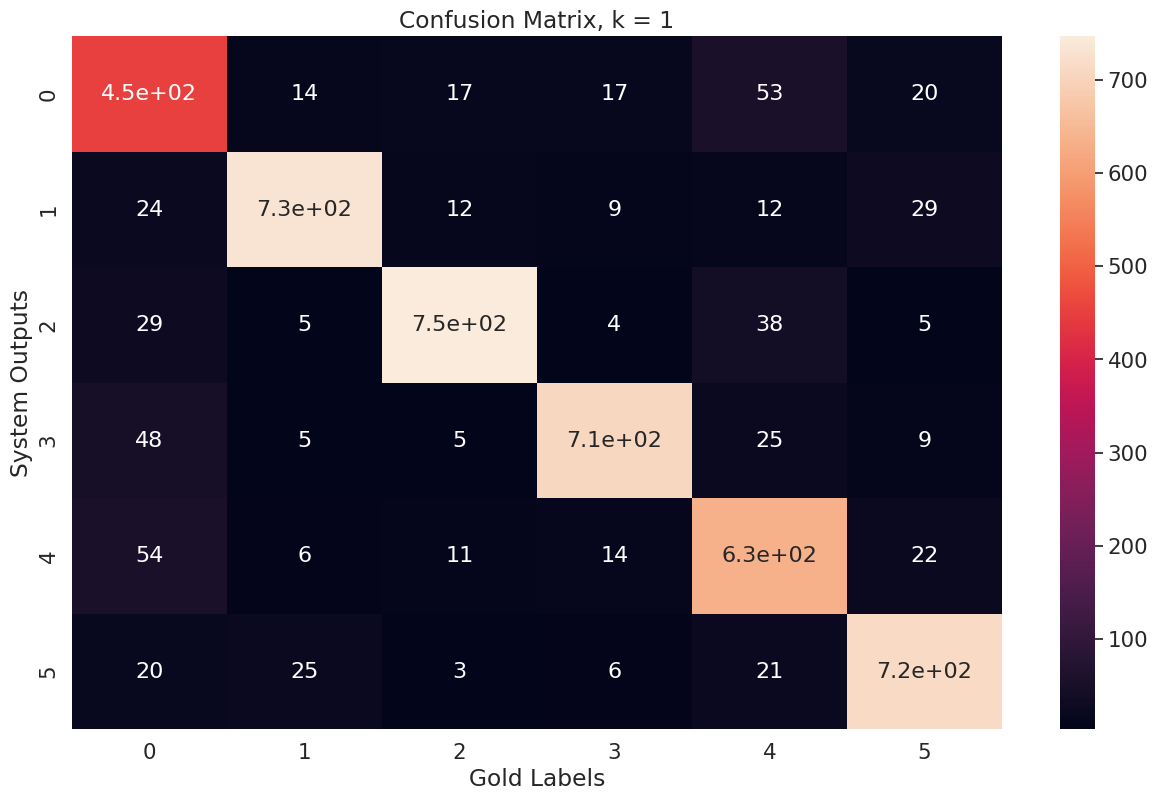

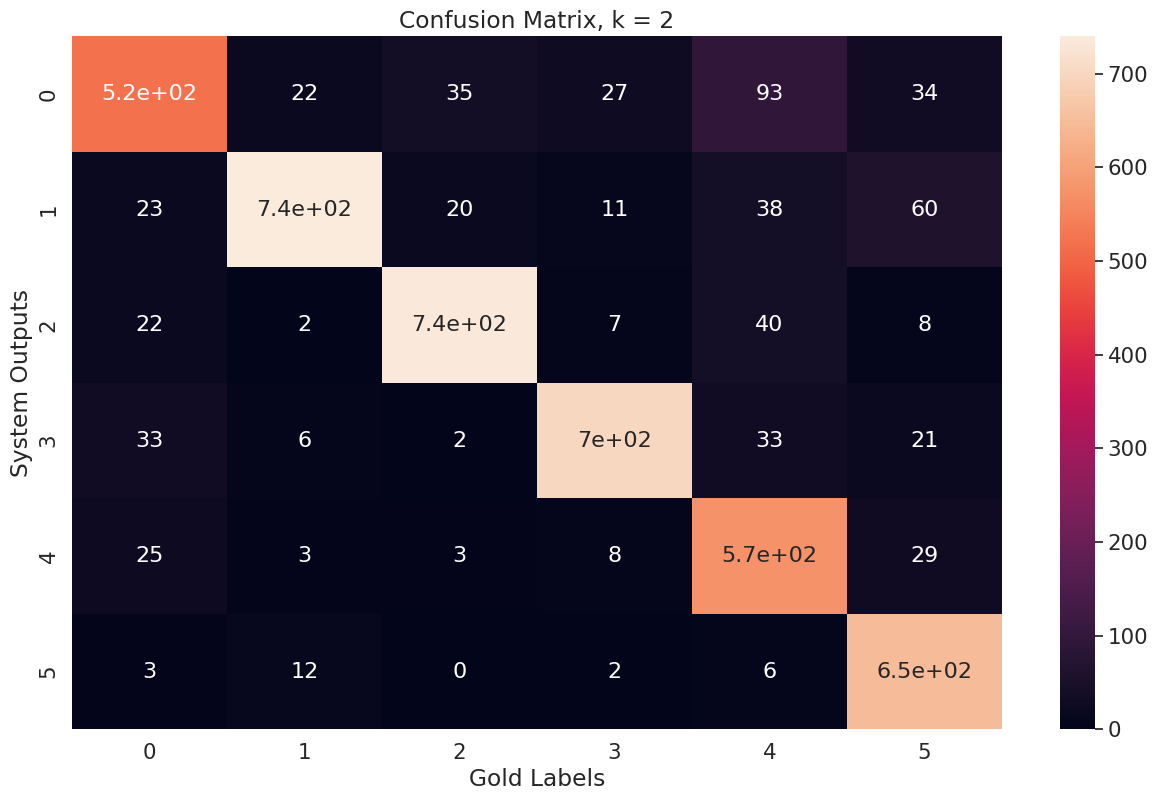

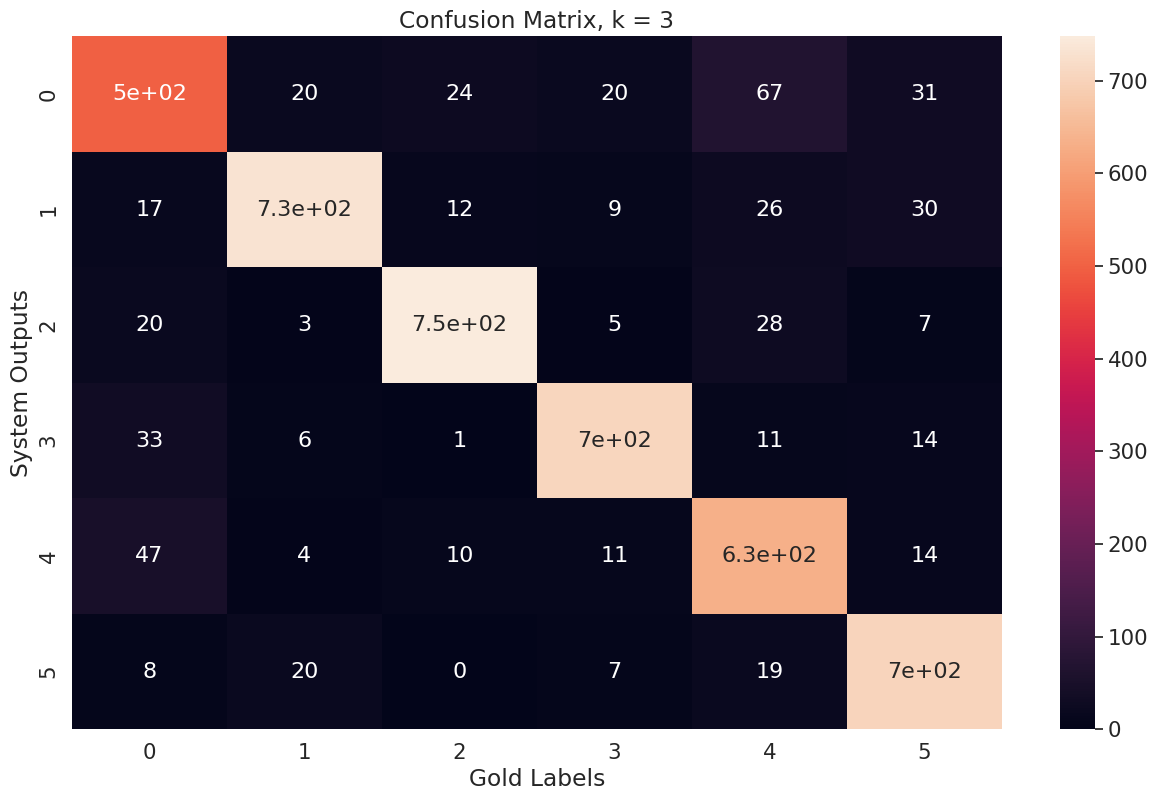

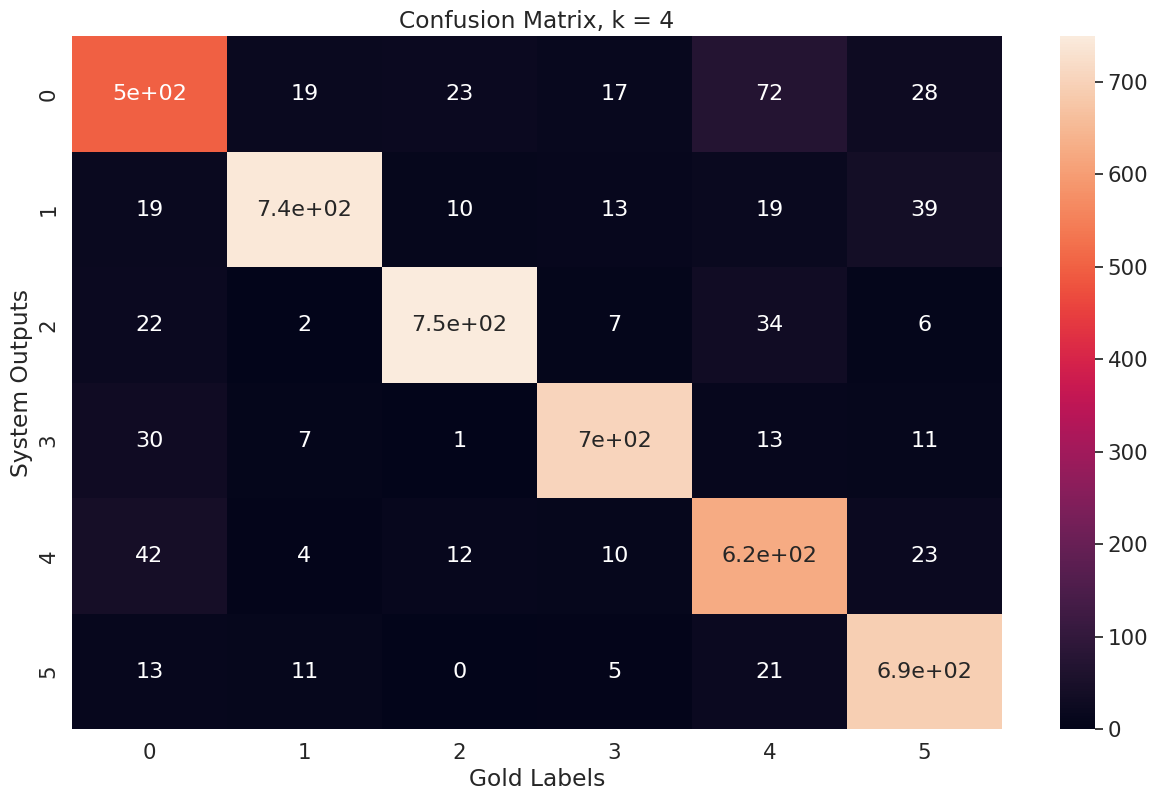

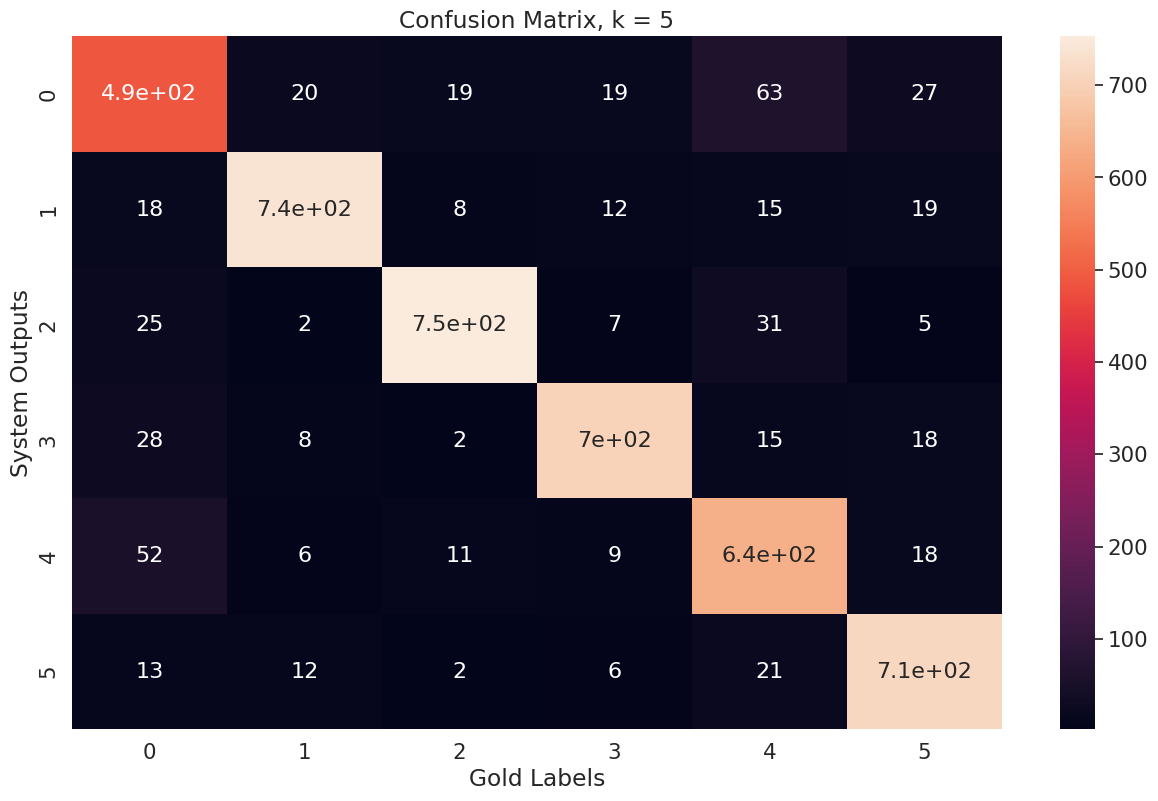

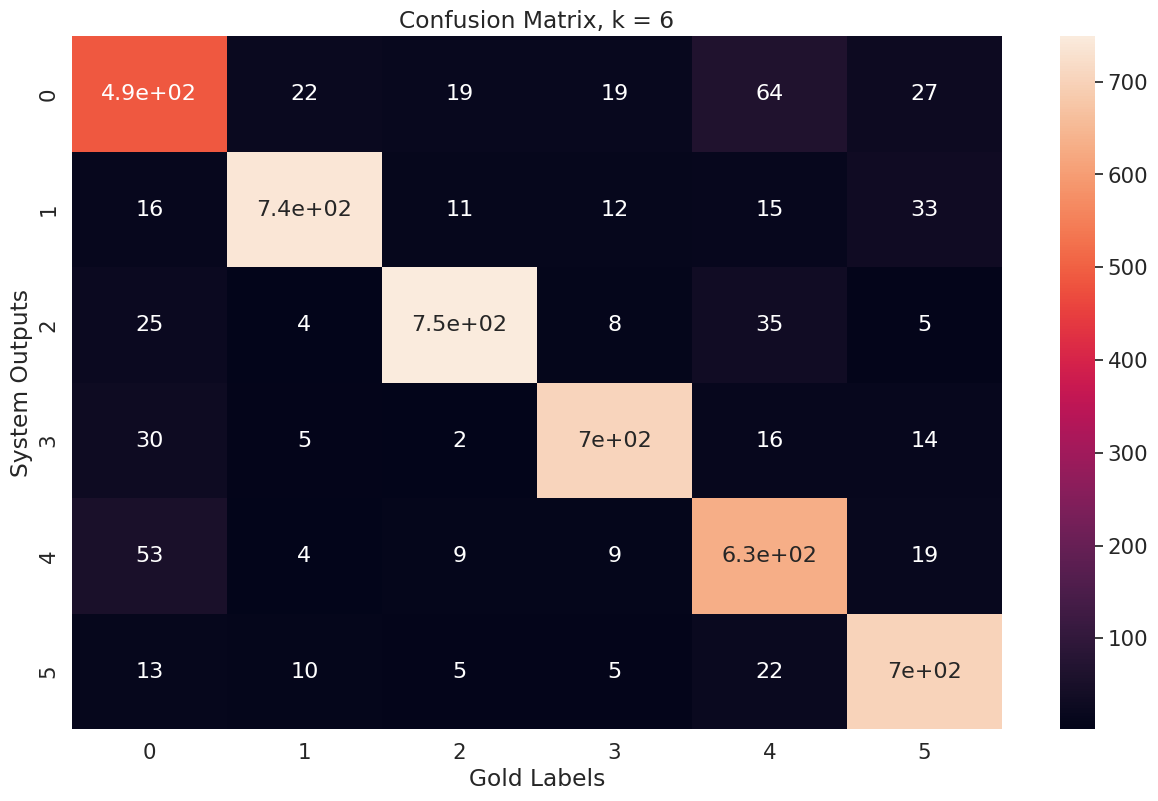

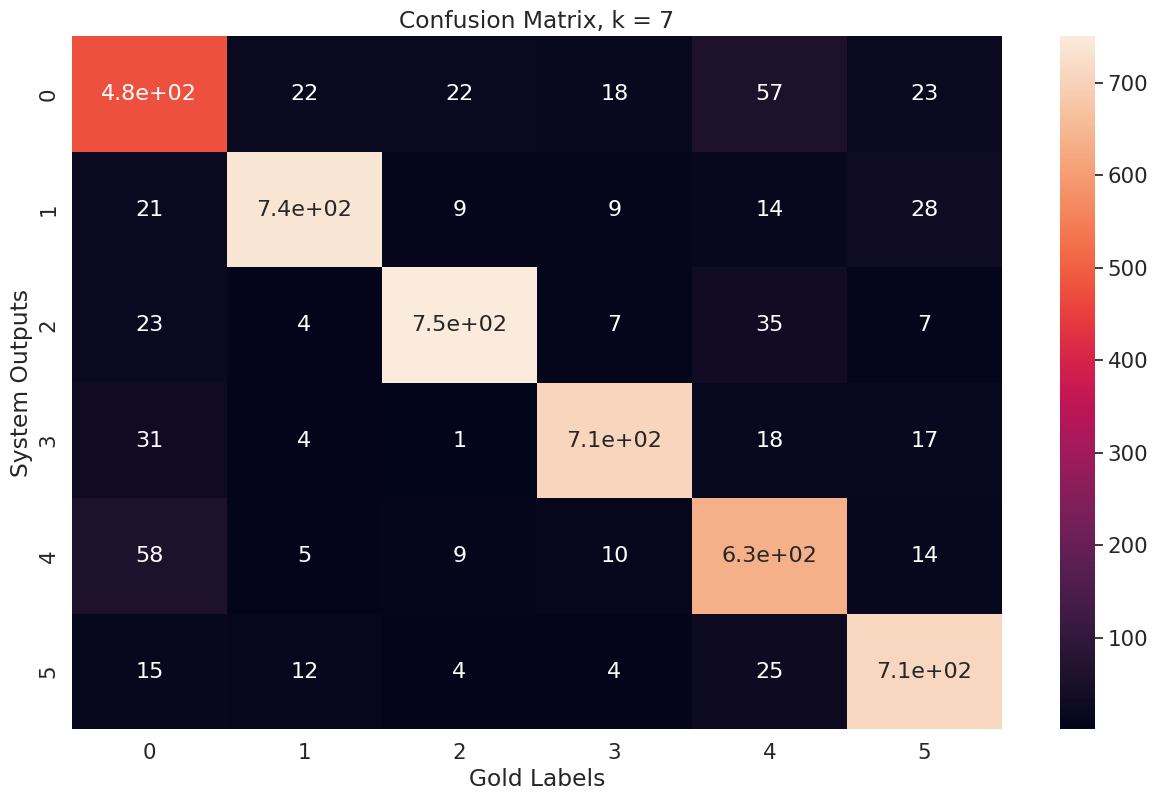

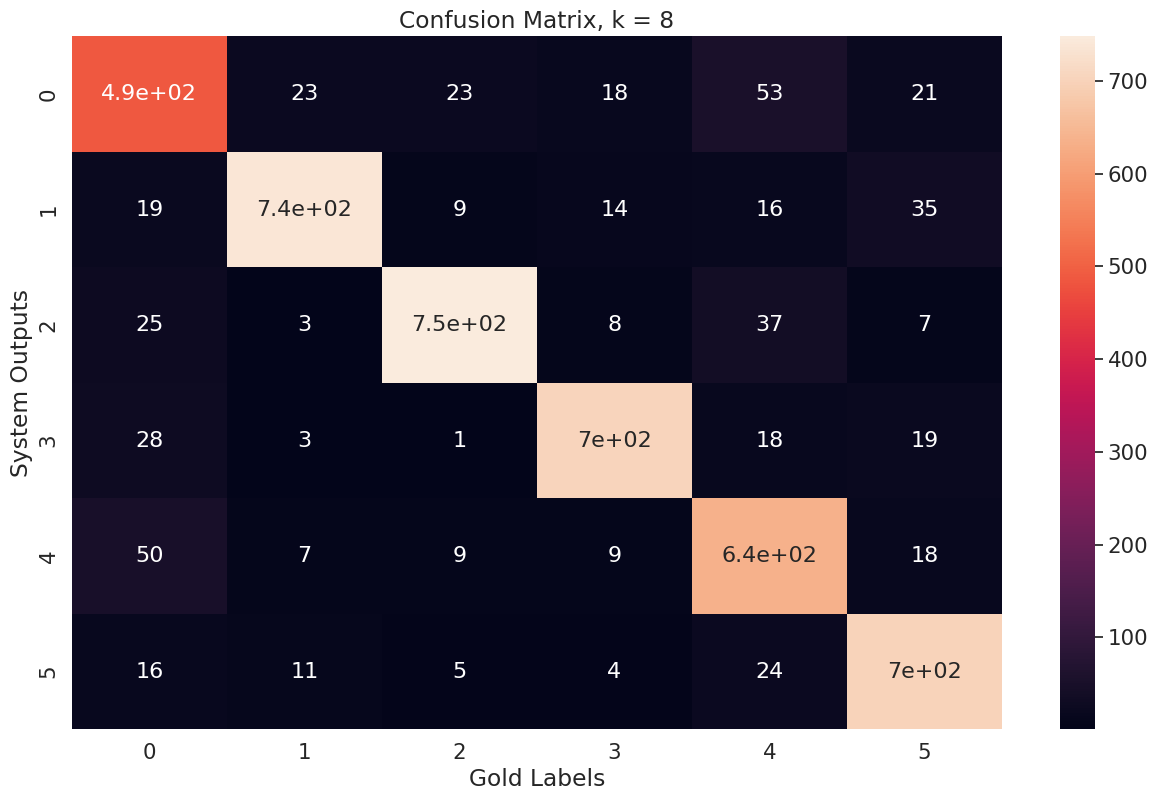

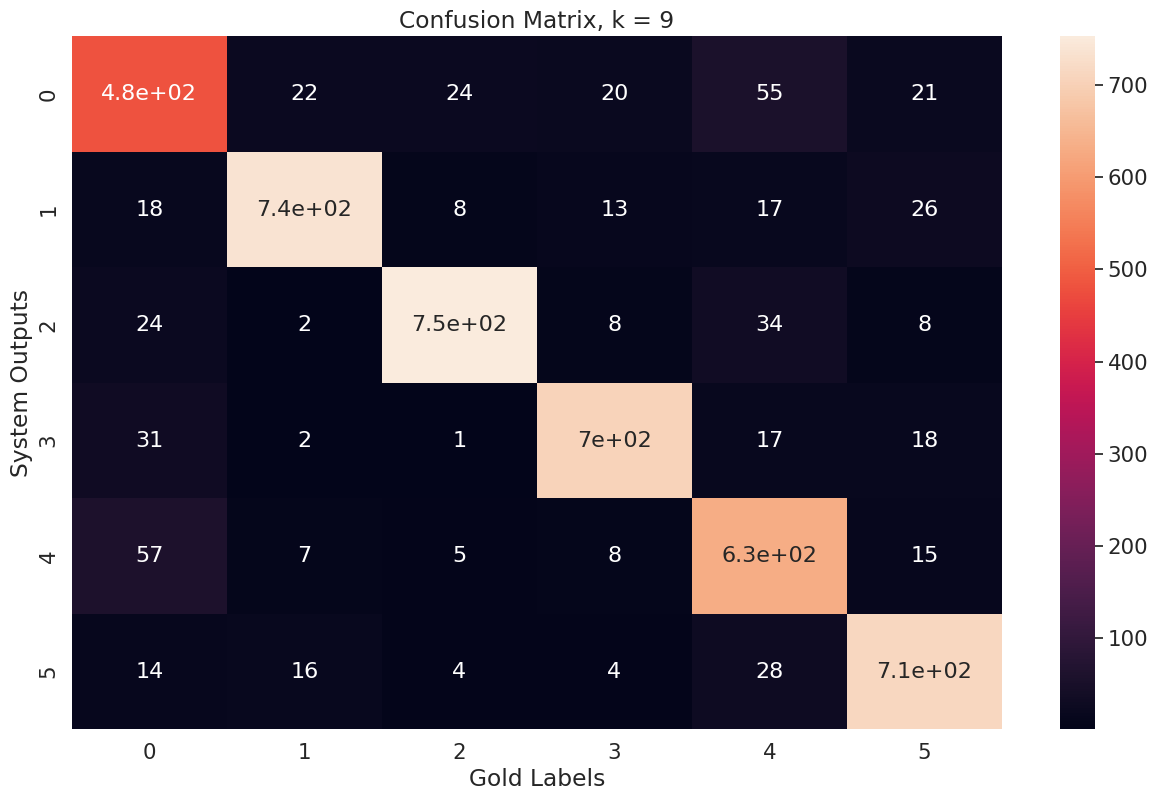

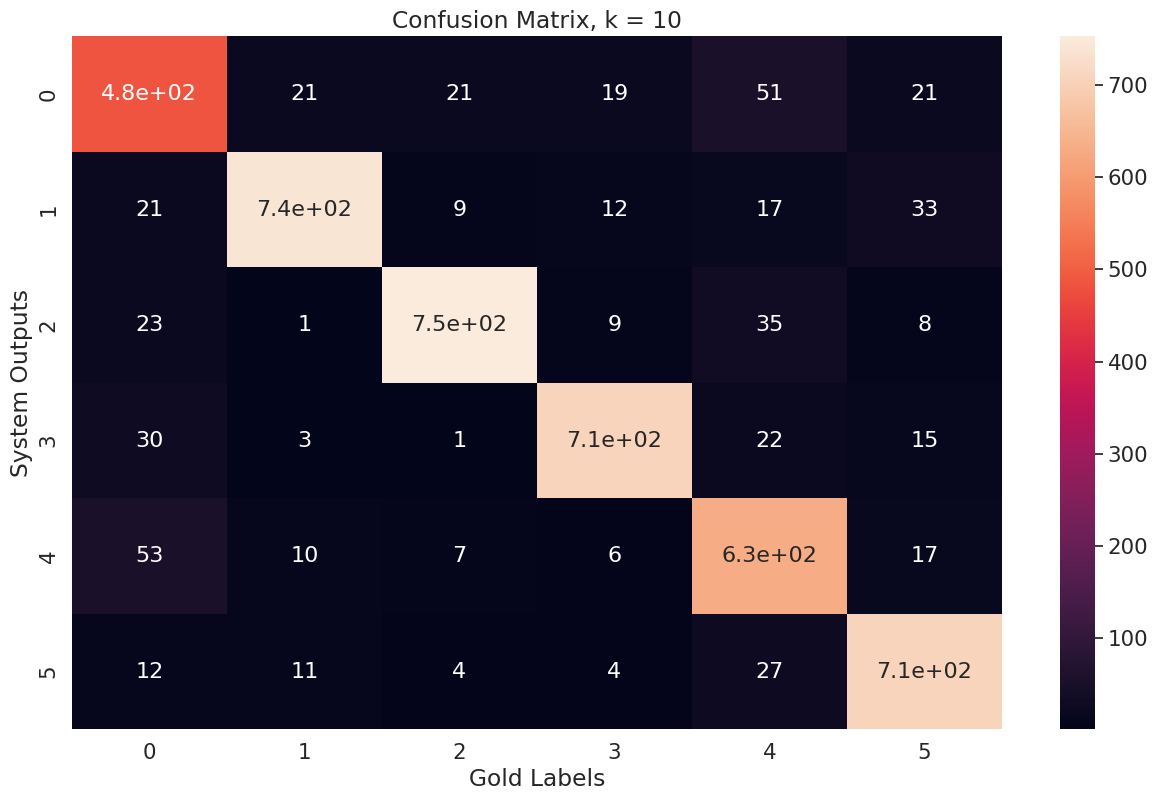

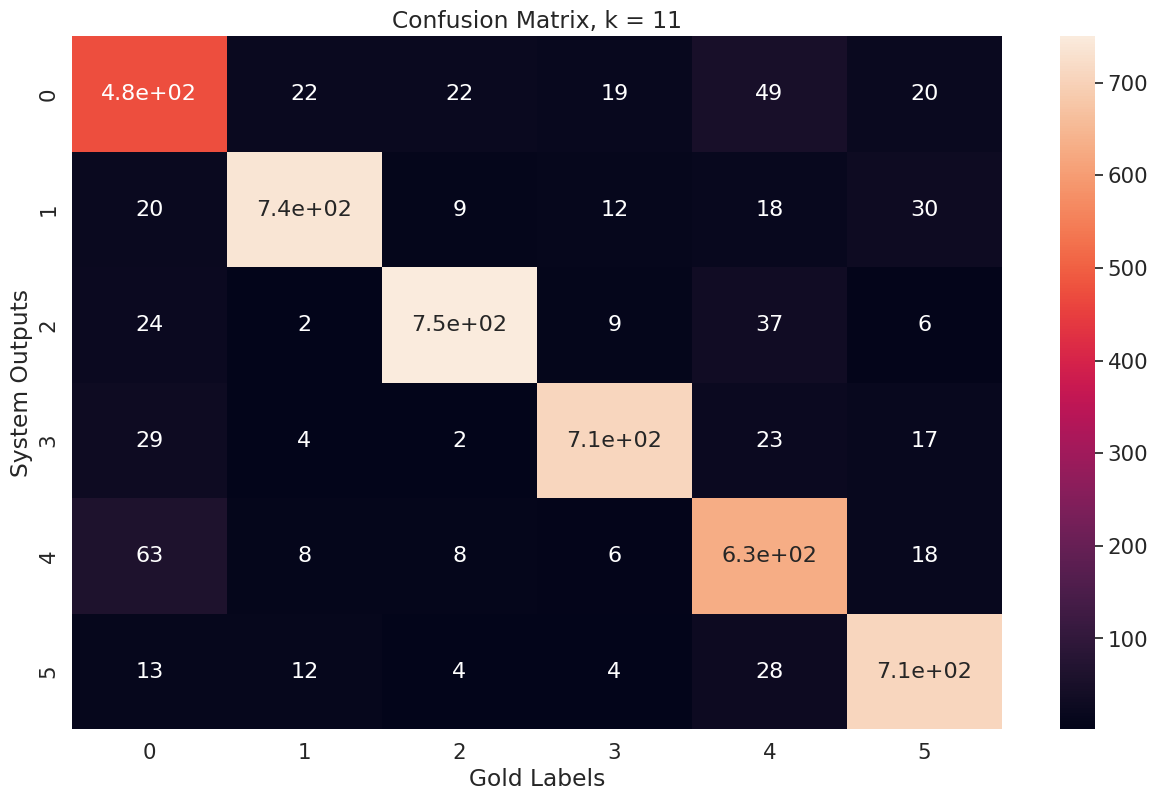

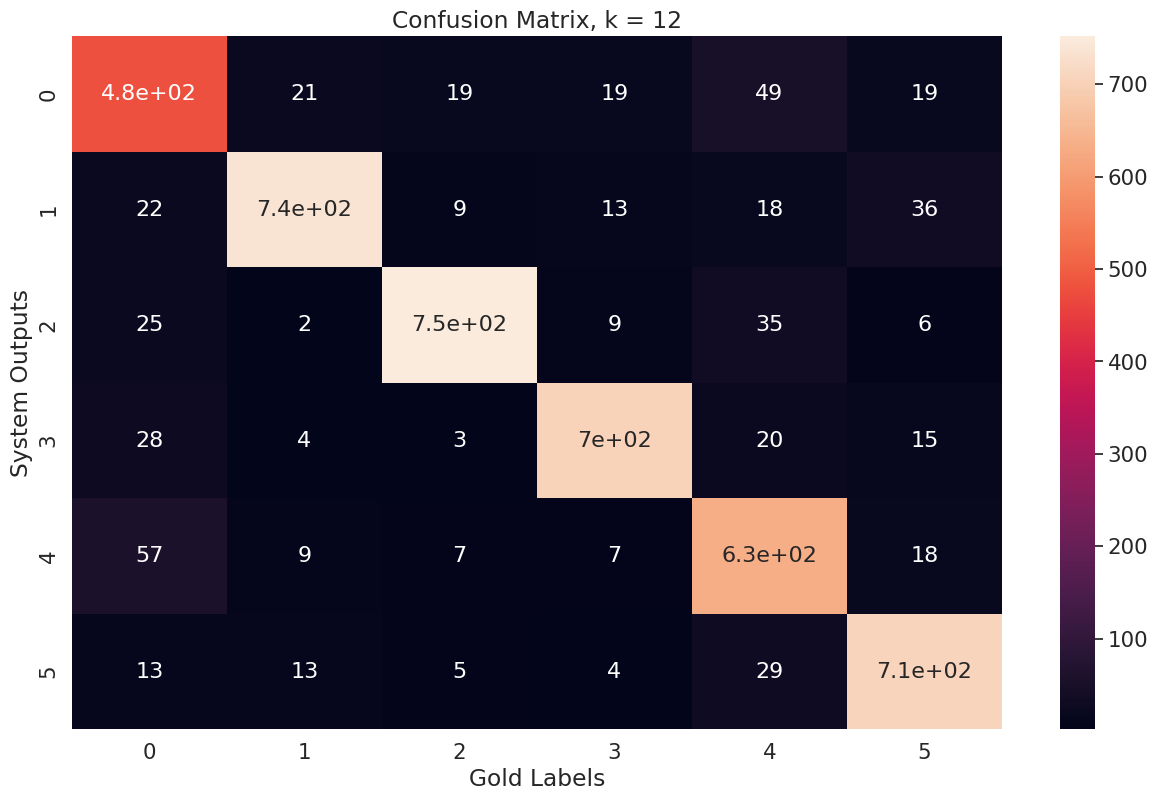

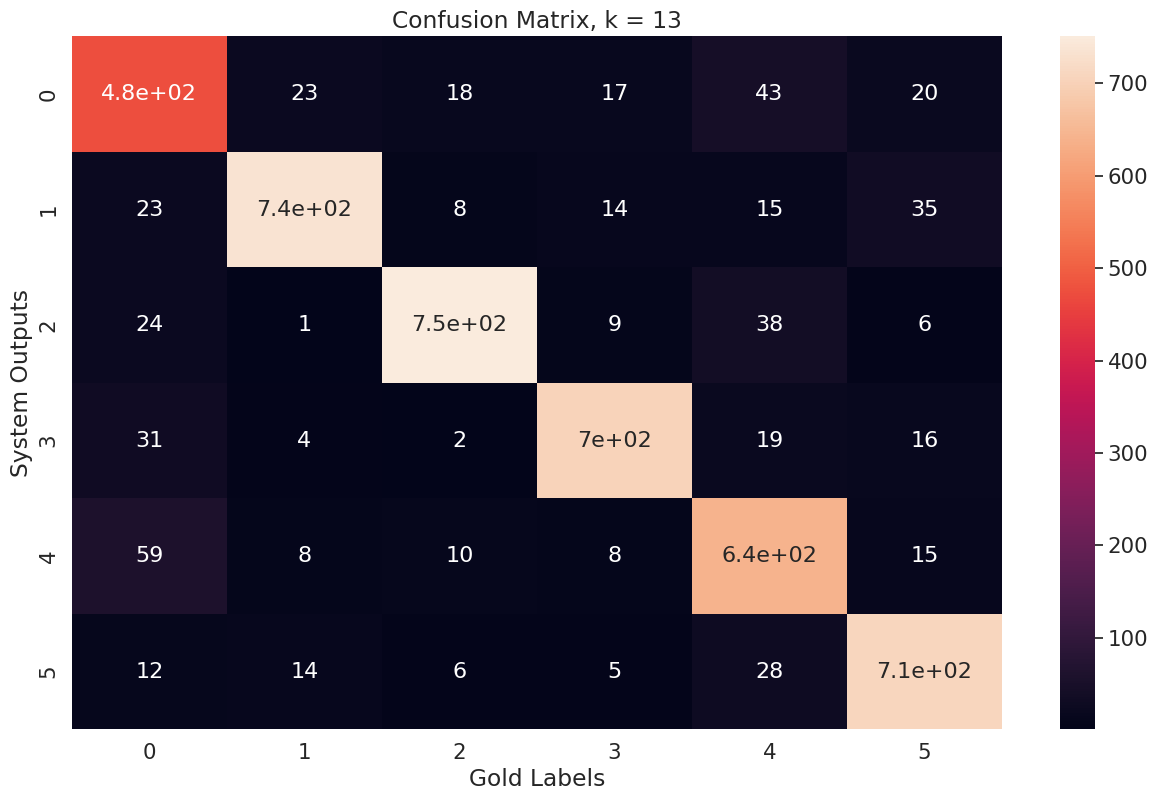

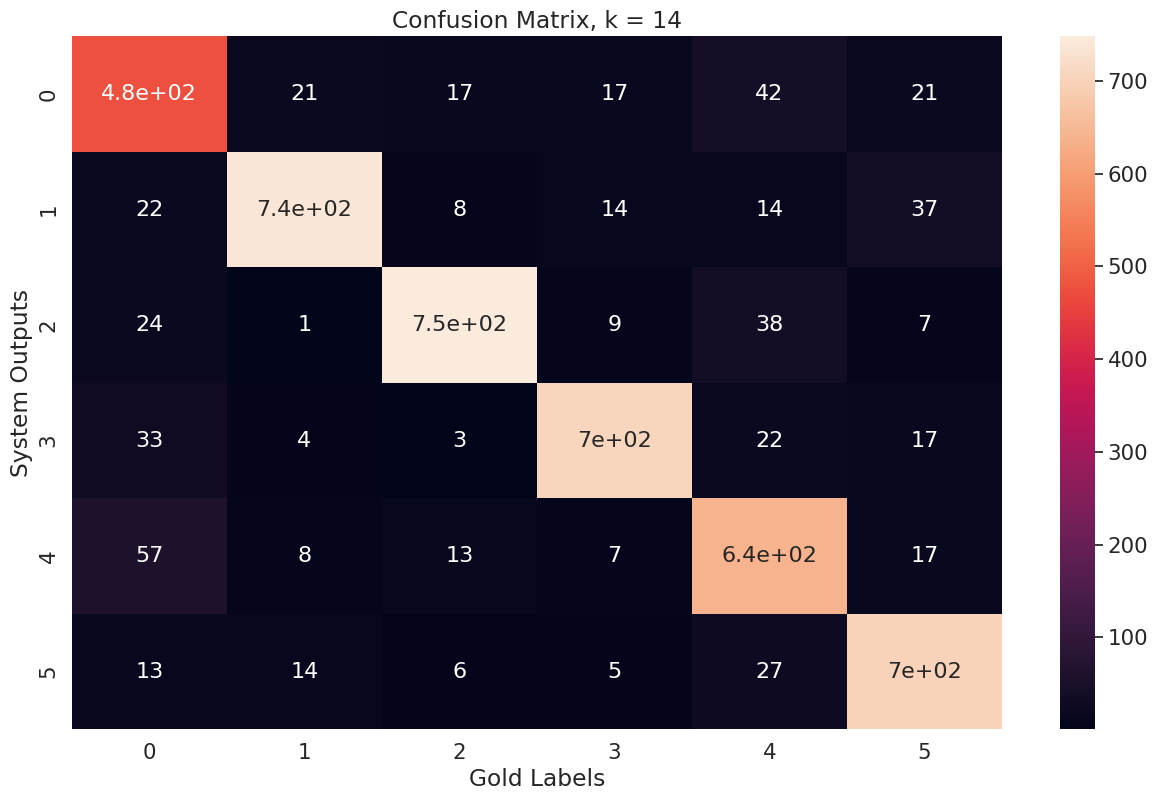

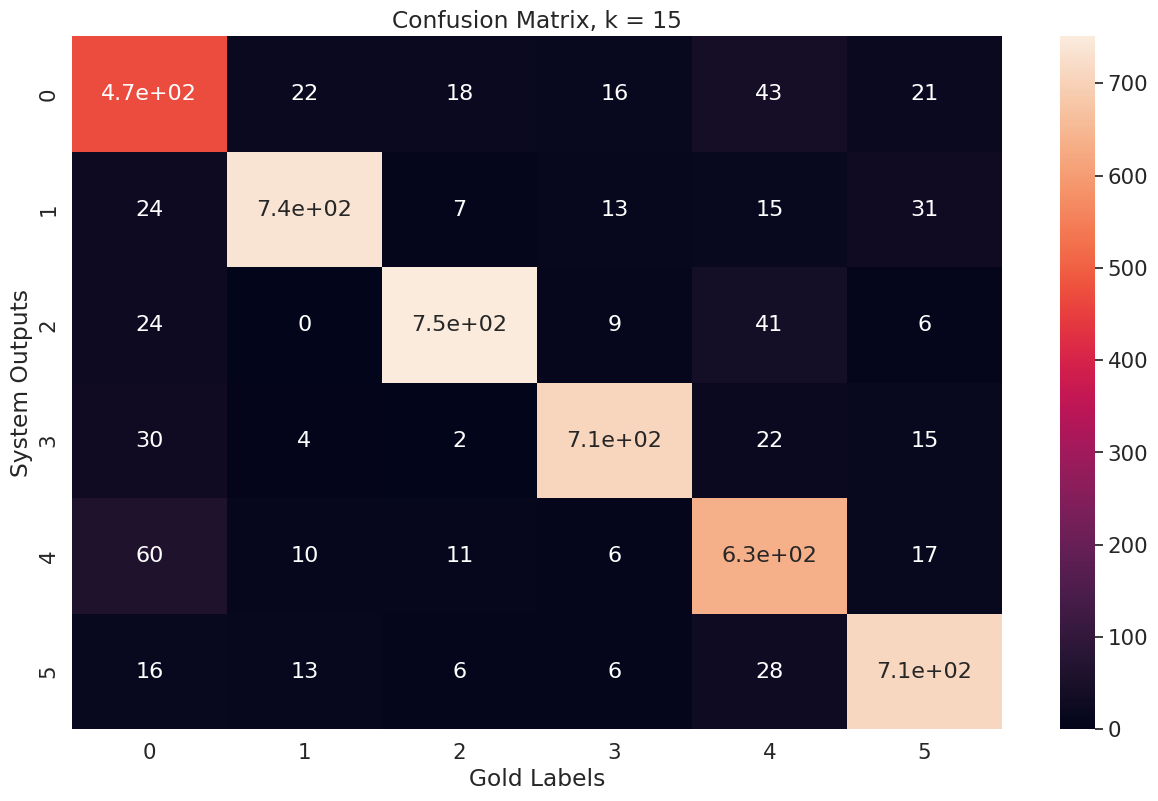

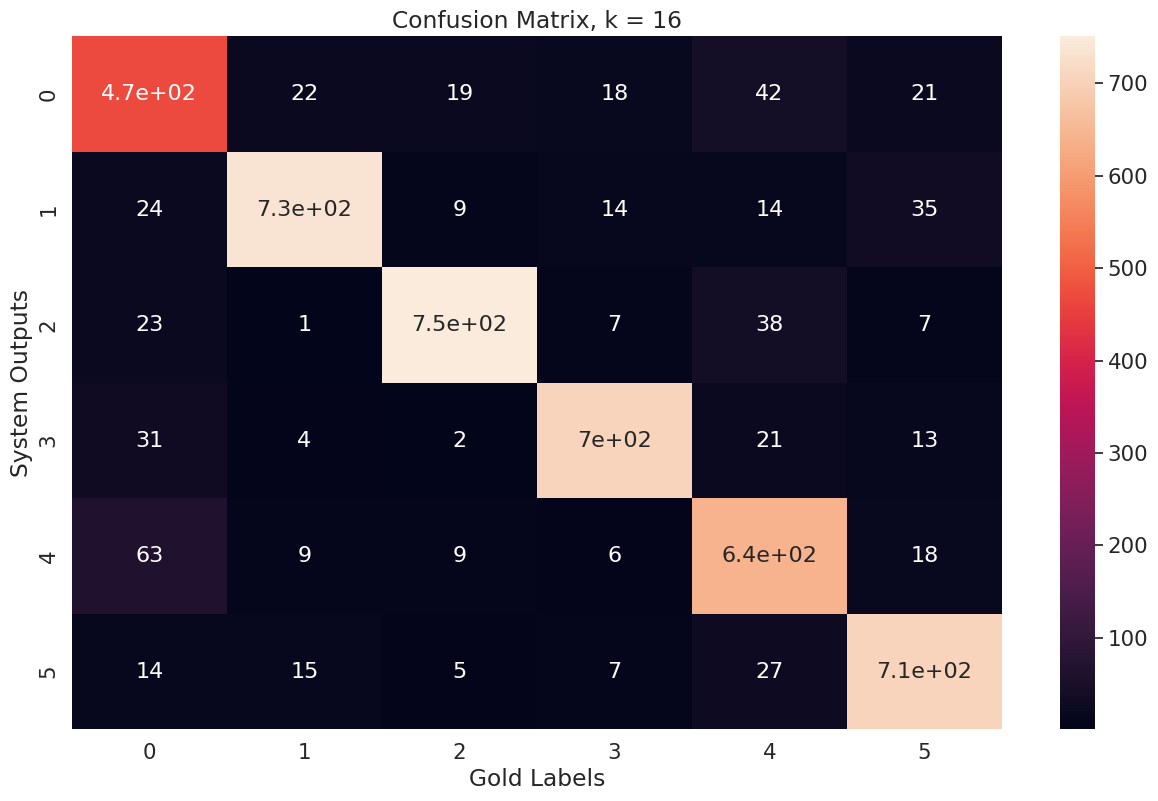

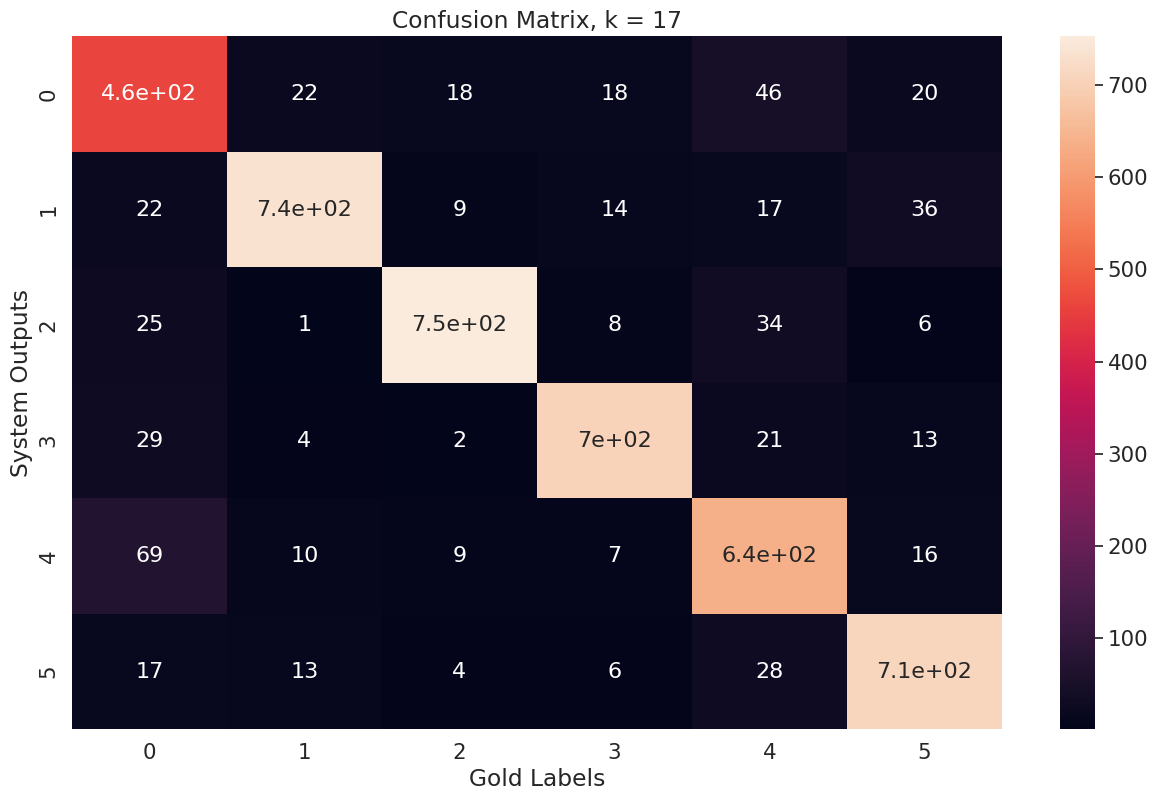

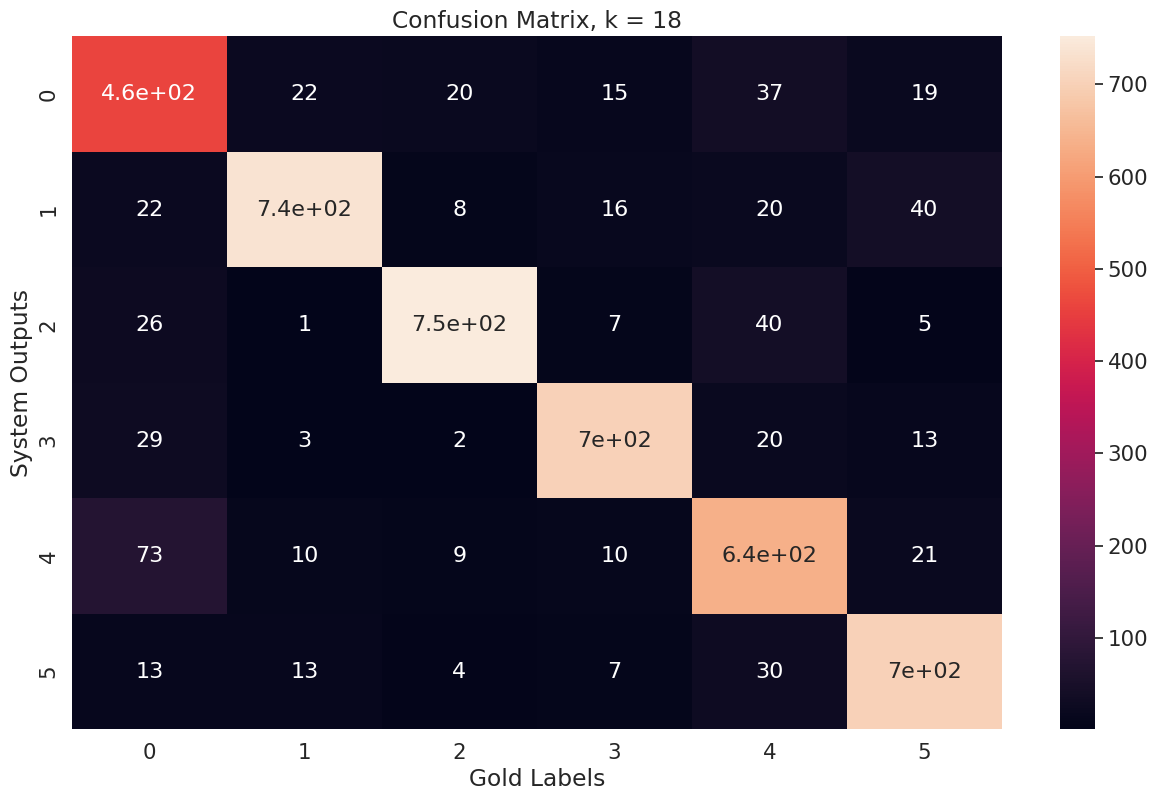

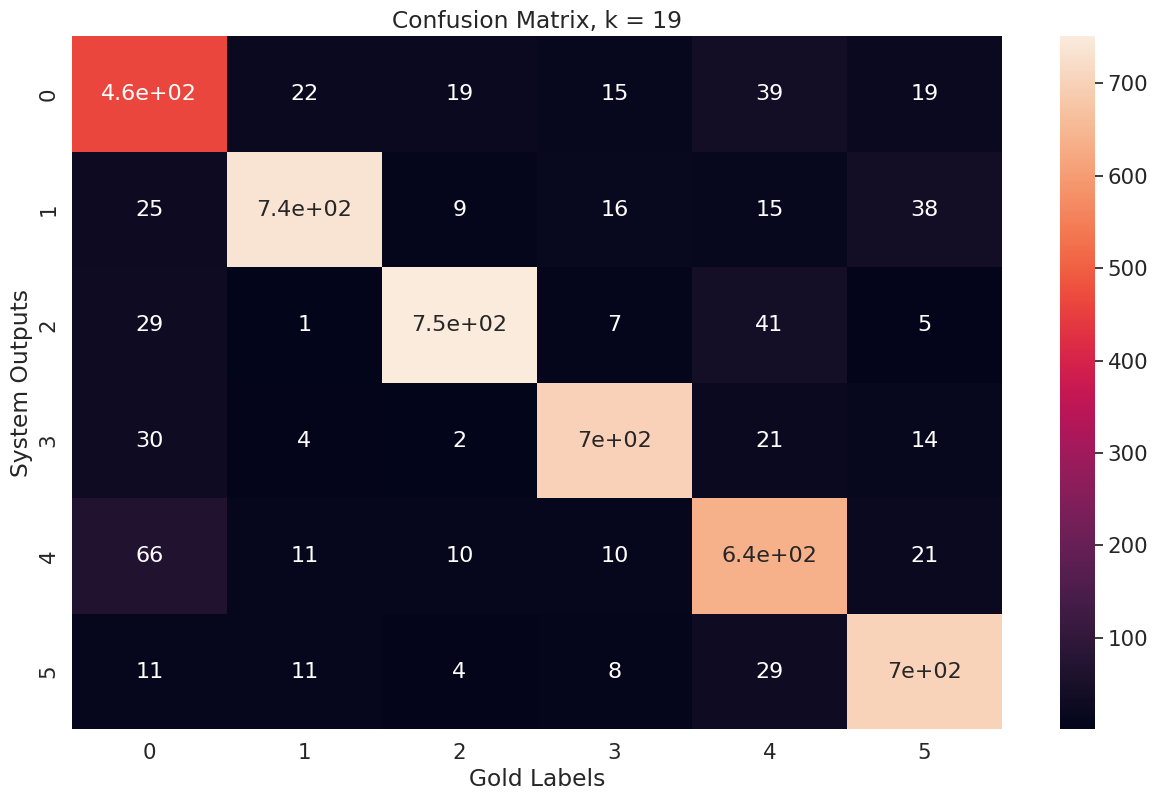

In [54]:


# training and validation
train = pd.read_csv("./train_embeddings_data.csv")
train_features = train["embeddings"]
train_labels = train["Twitter Handle"]

num_arr = [0, 1, 2, 3, 4, 5]
numeric_labels_dict = dict(zip(twitter_handles, num_arr))
m = 5
numClasses = 6 
accuracies = []
f1s = []


def make_numeric_labels(train_labels, numeric_labels_dict):
    result = []
    for ind in train_labels.index:
        result.append(numeric_labels_dict[train_labels[ind]])
    return result

def make_numeric_features(train_features):
    result = []
    for ind in train_features.index:
        features = train_features[ind].split()
        features[0] = features[0].replace("[", "")
        features[-1] = features[-1].replace("]", "")
        while '' in features:
            features.remove('')
        for i in range(len(features)):
            features[i] = float(features[i])
        result.append(features) 
    return result       

# training and cross-validation
train_Y = make_numeric_labels(train_labels, numeric_labels_dict)
train_X = make_numeric_features(train_features)

train_X = np.array(train_X)
train_Y = np.array(train_Y)

validation_losses = []
training_losses = []

for k in range(1, 20):
    preds = np.zeros(0)
    knn = KNeighborsClassifier(n_neighbors = k, metric='euclidean')
    preds = cross_val_predict(knn, train_X, train_Y, cv = m)
    accuracy = accuracy_score(train_Y, preds)
    accuracies = np.append(accuracies, accuracy)
    report = classification_report(train_Y, preds, output_dict = True)
    f1 = report["macro avg"]["f1-score"]
    f1s = np.append(f1s, f1)
    confusionMatrix = confusion_matrix(preds, train_Y)
    cm = pd.DataFrame(confusionMatrix, range(0, numClasses), range(0, numClasses))
    plt.figure(figsize=(15,9))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True,annot_kws={"size": 16})
    plt.xlabel("Gold Labels")
    plt.ylabel("System Outputs")
    plt.title("Confusion Matrix, k = " + str(k))
    plt.show()
    knn.fit(train_X, train_Y)
    train_loss = 1 - knn.score(train_X, train_Y)
    training_losses.append(train_loss)
    val_loss = 1 - np.mean(cross_val_score(knn, train_X, train_Y, cv=5))
    validation_losses.append(val_loss)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


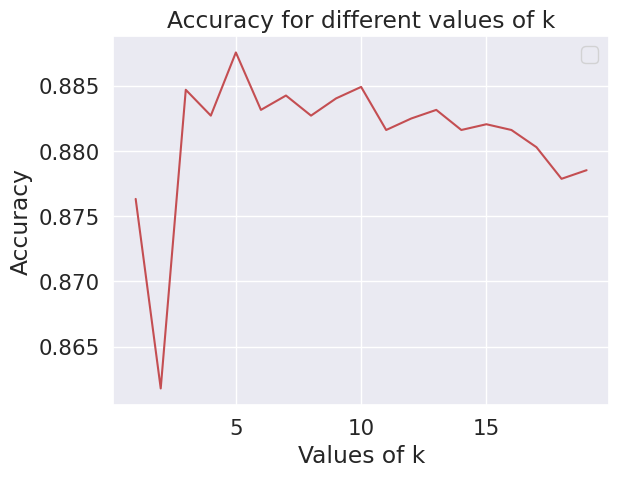

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


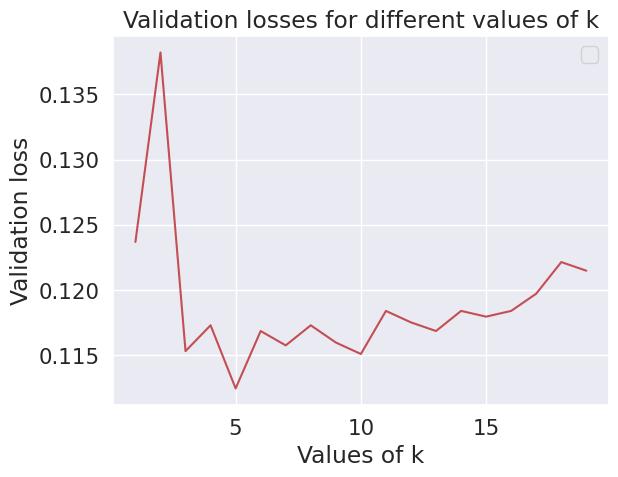

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


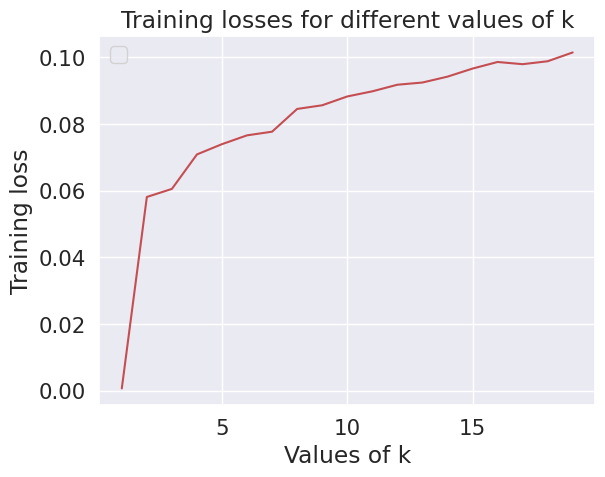

Best Value of k:  5


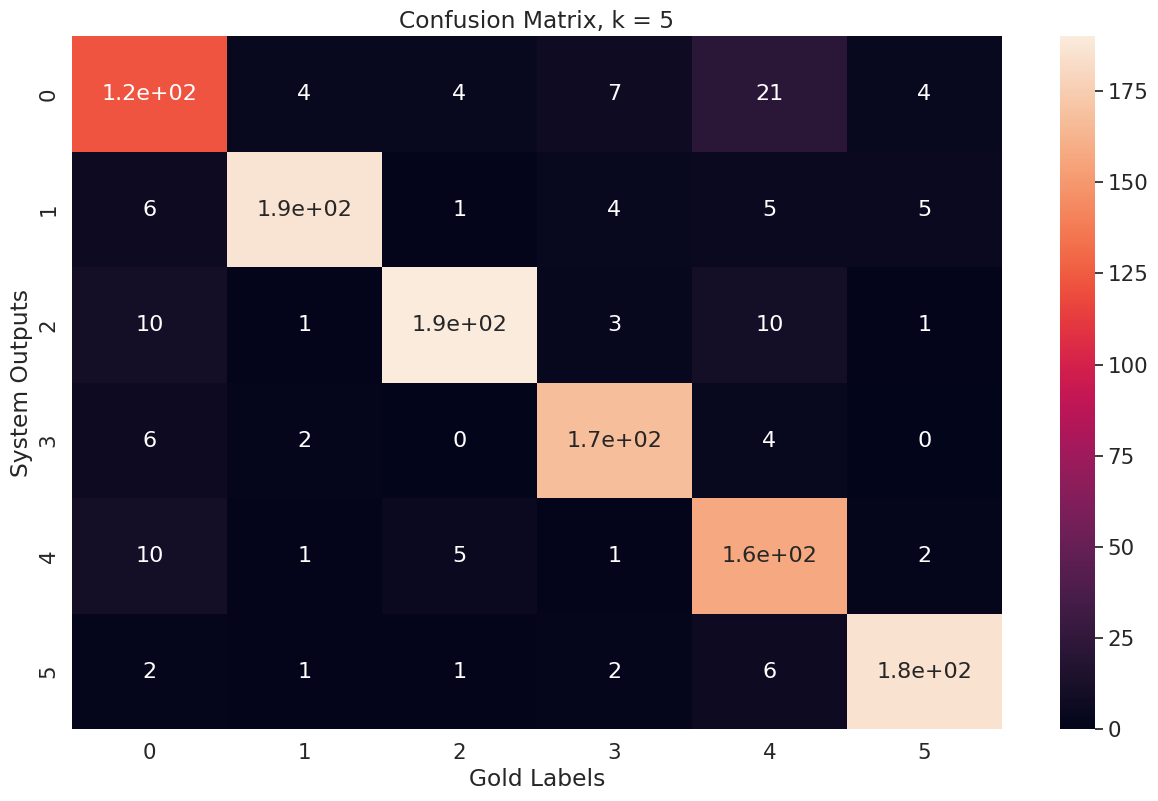

Classification Accuracy:  0.8865435356200527
Macro-Average F1:  0.8824538471645335
Macro-Average Precision:  0.8833434383543262
Macro-Average Recall:  0.8837293102880364


In [55]:

# plot f1s and accuracies to get best value of k
k = range(1, 20)

#  accuracy
plt.figure()
plt.plot(k, accuracies, "r")
plt.title("Accuracy for different values of k")
plt.xlabel("Values of k")
plt.legend()
plt.ylabel("Accuracy")
plt.show()


# validation loss
plt.figure()
plt.plot(k, validation_losses, "r")
plt.title("Validation losses for different values of k")
plt.xlabel("Values of k")
plt.legend()
plt.ylabel("Validation loss")
plt.show()

# training loss
plt.figure()
plt.plot(k, training_losses, "r")
plt.title("Training losses for different values of k")
plt.xlabel("Values of k")
plt.legend()
plt.ylabel("Training loss")
plt.show()

# best value of k
nparr = np.array(accuracies)
bestK = np.argmax(nparr) + 1
print("Best Value of k: ", bestK)
preds = []

test = pd.read_csv("./test_embeddings_data.csv")
test_features = test["embeddings"]
test_labels = test["Twitter Handle"]

knnTest = KNeighborsClassifier(n_neighbors = bestK, metric='euclidean')
knnTest.fit(train_X, train_Y)

test_X = make_numeric_features(test_features)
test_Y = make_numeric_labels(test_labels, numeric_labels_dict)
test_X = np.array(test_X)
test_Y = np.array(test_Y)

yTest = knnTest.predict(test_X)

accuracy = accuracy_score(test_Y, yTest)
reportT = classification_report(test_Y, yTest, output_dict = True)
f1T = reportT["macro avg"]["f1-score"]

confusionMatrix = confusion_matrix(yTest, test_Y)   
cm = pd.DataFrame(confusionMatrix, range(0, numClasses), range(0, numClasses))
plt.figure(figsize=(15,9))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16})
plt.xlabel("Gold Labels")
plt.ylabel("System Outputs")
plt.title("Confusion Matrix, k = " + str(bestK))
plt.show()

print("Classification Accuracy: ", accuracy)
print("Macro-Average F1: ", f1T)
print("Macro-Average Precision: ", reportT["macro avg"]["precision"])
print("Macro-Average Recall: ", reportT["macro avg"]["recall"])

### Task 3: NNs
Use scikit-learn’s Neural Network implementation to train and test the Neural Network on the
provided dataset. Do 5-fold cross-validation and report the validation and training losses using
graphs. Use scikit-learn’s accuracy_score function to calculate the accuracy,
classification_report to calculate macro-average (precision, recall, and F1), and
confusion_matrix function to calculate confusion matrix on the test set.
Do this for both types of features separately.

#### BOW features

In [56]:
train = pd.read_csv("./train_data.csv")
train_features = train["BOWs"]
train_labels = train["Twitter Handle"]
num_arr = [0, 1, 2, 3, 4, 5]
numeric_labels_dict = dict(zip(twitter_handles, num_arr))
m = 5
numClasses = 6 
accuracies = []
f1s = []

def make_numeric_labels(train_labels, numeric_labels_dict):
    result = []
    for ind in train_labels.index:
        result.append(numeric_labels_dict[train_labels[ind]])
    return result

def make_numeric_features(train_features):
    result = []
    for ind in train_features.index:
        features = train_features[ind].split()
        features[0] = features[0].replace("[", "")
        features[-1] = features[-1].replace("]", "")
        for i in range(len(features)):
            features[i] = features[i].replace(",", "")
            features[i] = int(features[i])
        result.append(features) 
    return result       

# training and cross-validation

train_Y = make_numeric_labels(train_labels, numeric_labels_dict)
train_X = make_numeric_features(train_features)

train_X = np.array(train_X)
train_Y = np.array(train_Y)

training_losses = []
validation_losses = []

In [57]:
kf = KFold(n_splits=m)
clf = MLPClassifier(hidden_layer_sizes=(400, 200, 100, 50, 25), solver='sgd', max_iter=500, alpha=0.003, learning_rate='adaptive')

indices = []
# this code uses kfold 
for train_indices, val_indices in kf.split(train_X):
    val_X = [train_X[i] for i in val_indices]
    val_Y = [train_Y[i] for i in val_indices]

    train_data_X = [train_X[i] for i in train_indices]
    train_data_Y = [train_Y[i] for i in train_indices]
    
    clf.fit(train_data_X, train_data_Y)
    
    train_loss = 1 - clf.score(train_data_X, train_data_Y)
    training_losses.append(train_loss)
    
    val_loss = 1 - clf.score(val_X, val_Y)
    validation_losses.append(val_loss)
    
    indices.append(train_indices) 

/home/sumair/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sumair/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sumair/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sumair/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sumair/.local/lib/python3.11/site-packages

In [58]:
# getting the best data indices from cross-validation
best_one = np.argmin(validation_losses)
train_indices = indices[best_one]
new_X_train = [train_X[i] for i in train_indices]
new_Y_train = [train_Y[i] for i in train_indices]

clf.fit(new_X_train, new_Y_train)


MLPClassifier(alpha=0.003, hidden_layer_sizes=(400, 200, 100, 50, 25),
              learning_rate='adaptive', max_iter=500, solver='sgd')

In [59]:

test = pd.read_csv("./test_data.csv")
test_features = test["BOWs"]
test_labels = test["Twitter Handle"]

test_X = make_numeric_features(test_features)
test_Y = make_numeric_labels(test_labels, numeric_labels_dict)

test_X = np.array(test_X)
test_Y = np.array(test_Y)

yTest = clf.predict(test_X)

/home/sumair/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sumair/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sumair/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


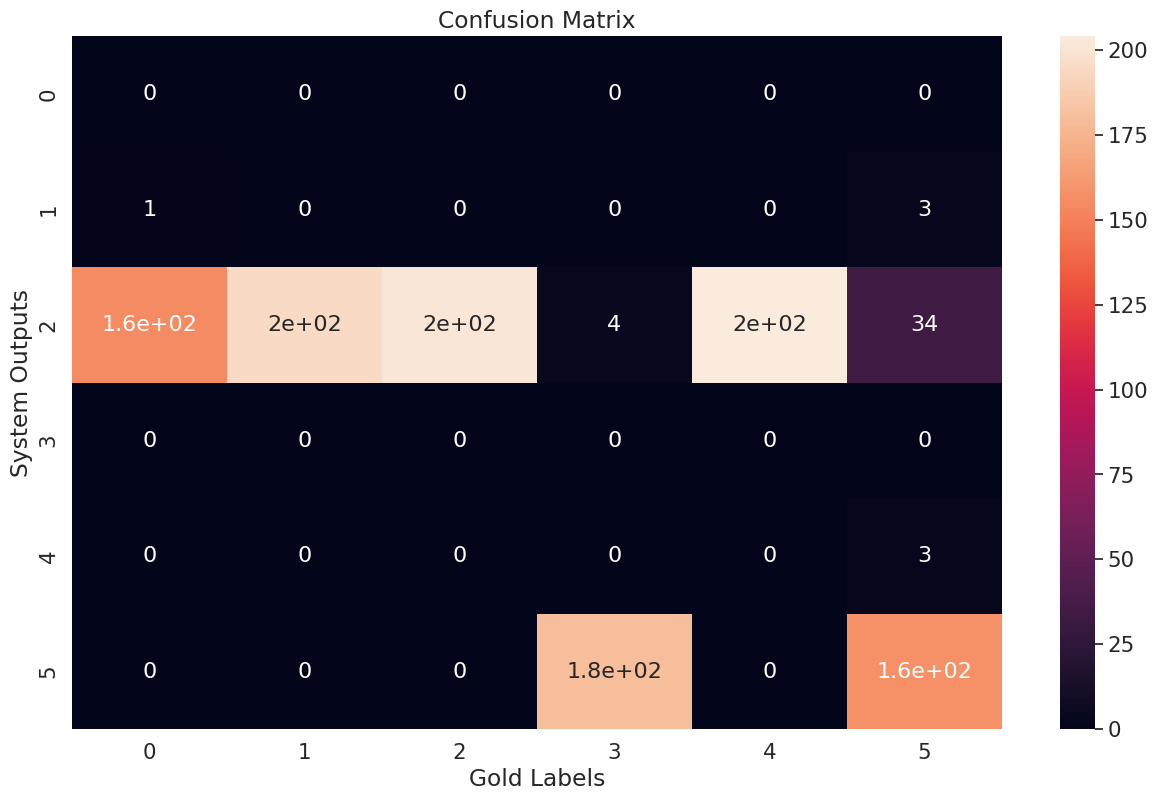

Classification Accuracy:  0.3148636763412489
Macro-Average F1:  0.1654069234382575
Macro-Average Precision:  0.1198905357586099
Macro-Average Recall:  0.299492385786802


In [60]:

accuracy = accuracy_score(test_Y, yTest)
reportT = classification_report(test_Y, yTest, output_dict = True)
f1T = reportT["macro avg"]["f1-score"]

confusionMatrix = confusion_matrix(yTest, test_Y)   
cm = pd.DataFrame(confusionMatrix, range(0, numClasses), range(0, numClasses))
plt.figure(figsize=(15,9))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16})
plt.xlabel("Gold Labels")
plt.ylabel("System Outputs")
plt.title("Confusion Matrix")
plt.show()

print("Classification Accuracy: ", accuracy)
print("Macro-Average F1: ", f1T)
print("Macro-Average Precision: ", reportT["macro avg"]["precision"])
print("Macro-Average Recall: ", reportT["macro avg"]["recall"])

#### Embeddings features

In [14]:

train = pd.read_csv("./train_embeddings_data.csv")
train_features = train["embeddings"]
train_labels = train["Twitter Handle"]

num_arr = [0, 1, 2, 3, 4, 5]
numeric_labels_dict = dict(zip(twitter_handles, num_arr))
m = 5
numClasses = 6 
accuracies = []
f1s = []


def make_numeric_labels(train_labels, numeric_labels_dict):
    result = []
    for ind in train_labels.index:
        result.append(numeric_labels_dict[train_labels[ind]])
    return result

def make_numeric_features(train_features):
    result = []
    for ind in train_features.index:
        features = train_features[ind].split()
        features[0] = features[0].replace("[", "")
        features[-1] = features[-1].replace("]", "")
        while '' in features:
            features.remove('')
        for i in range(len(features)):
            features[i] = float(features[i])
        result.append(features) 
    return result       

# training and cross-validation
train_Y = make_numeric_labels(train_labels, numeric_labels_dict)
train_X = make_numeric_features(train_features)

train_X = np.array(train_X)
train_Y = np.array(train_Y)

validation_losses = []
training_losses = []

kf = KFold(n_splits=m)
clf = MLPClassifier(hidden_layer_sizes=(400, 200, 100, 50, 25), solver='sgd', max_iter=500, alpha=0.003, learning_rate='adaptive')


indices = []
# this code uses kfold
for train_indices, val_indices in kf.split(train_X):
    val_X = [train_X[i] for i in val_indices]
    val_Y = [train_Y[i] for i in val_indices]

    train_data_X = [train_X[i] for i in train_indices]
    train_data_Y = [train_Y[i] for i in train_indices]

    clf.fit(train_data_X, train_data_Y)

    train_loss = 1 - clf.score(train_data_X, train_data_Y)
    training_losses.append(train_loss)

    val_loss = 1 - clf.score(val_X, val_Y)
    validation_losses.append(val_loss)

    indices.append(train_indices)


/home/sumair/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
# getting the best data indices from cross-validation
best_one = np.argmin(validation_losses)
train_indices = indices[best_one]
new_X_train = [train_X[i] for i in train_indices]
new_Y_train = [train_Y[i] for i in train_indices]

clf.fit(new_X_train, new_Y_train)

test = pd.read_csv("./test_embeddings_data.csv")
test_features = test["embeddings"]

test_labels = test["Twitter Handle"]

test_X = make_numeric_features(test_features)
test_Y = make_numeric_labels(test_labels, numeric_labels_dict)

test_X = np.array(test_X)
test_Y = np.array(test_Y)

yTest = clf.predict(test_X)


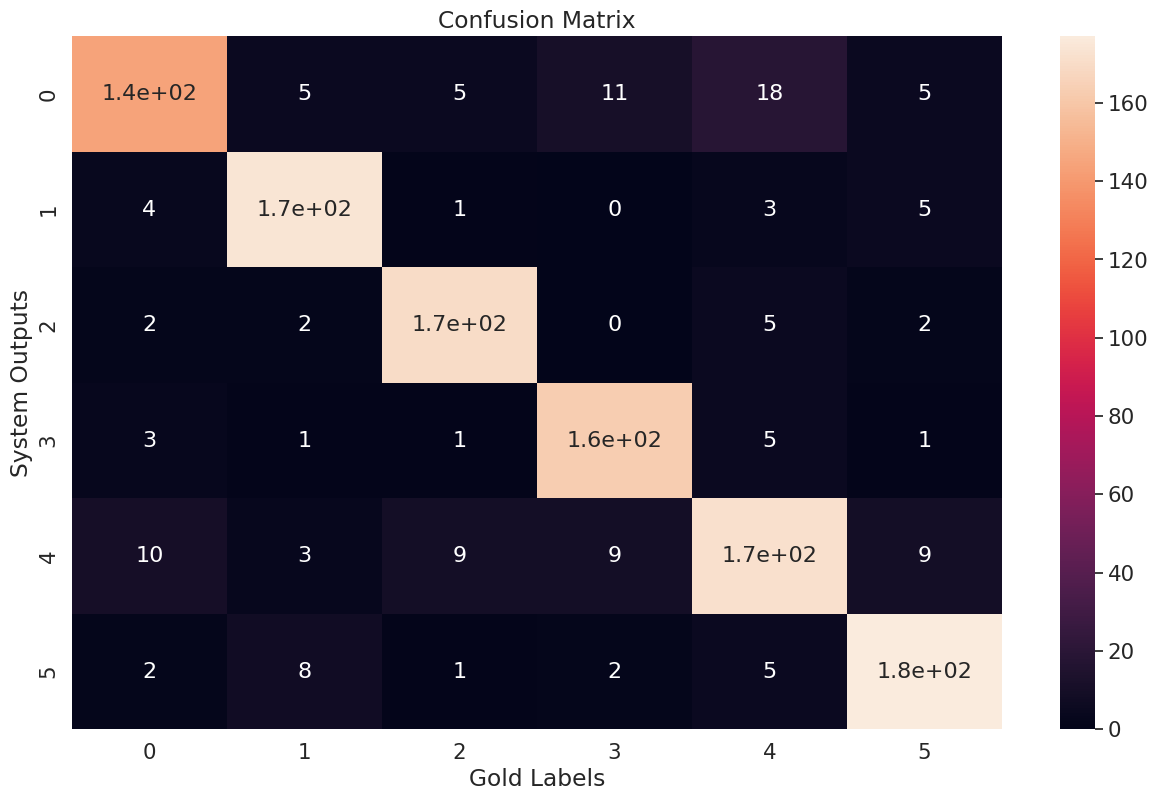

Classification Accuracy:  0.8795074758135444
Macro-Average F1:  0.8801948851103926
Macro-Average Precision:  0.8819099868621132
Macro-Average Recall:  0.8801373300247204


In [16]:
accuracy = accuracy_score(test_Y, yTest)
reportT = classification_report(test_Y, yTest, output_dict=True)
f1T = reportT["macro avg"]["f1-score"]

confusionMatrix = confusion_matrix(yTest, test_Y)
cm = pd.DataFrame(confusionMatrix, range(0, numClasses), range(0, numClasses))
plt.figure(figsize=(15, 9))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16})
plt.xlabel("Gold Labels")
plt.ylabel("System Outputs")
plt.title("Confusion Matrix")
plt.show()

print("Classification Accuracy: ", accuracy)
print("Macro-Average F1: ", f1T)
print("Macro-Average Precision: ", reportT["macro avg"]["precision"])
print("Macro-Average Recall: ", reportT["macro avg"]["recall"])

### Task 4: Ensemble Methods
Use ensemble methods for training and prediction. There are multiple methods you could use:
Bagging, Boosting, Voting, etc. You are free to try these out and use the one you feel performs
best on your dataset for the final submission. Use scikit-learn’s accuracy_score function to
calculate the accuracy, classification_report to calculate macro-average (precision, recall, and
F1), and confusion_matrix function to calculate confusion matrix on the test set.
Do this for both types of features separately.

#### BOW features

In [61]:
# read data
train = pd.read_csv("./train_data.csv")
train_features = train["BOWs"]
train_labels = train["Twitter Handle"]
num_arr = [0, 1, 2, 3, 4, 5]
numeric_labels_dict = dict(zip(twitter_handles, num_arr))
m = 5
numClasses = 6
accuracies = []
f1s = []


def make_numeric_labels(train_labels, numeric_labels_dict):
    result = []
    for ind in train_labels.index:
        result.append(numeric_labels_dict[train_labels[ind]])
    return result


def make_numeric_features(train_features):
    result = []
    for ind in train_features.index:
        features = train_features[ind].split()
        features[0] = features[0].replace("[", "")
        features[-1] = features[-1].replace("]", "")
        for i in range(len(features)):
            features[i] = features[i].replace(",", "")
            features[i] = int(features[i])
        result.append(features)
    return result


train_Y = make_numeric_labels(train_labels, numeric_labels_dict)
train_X = make_numeric_features(train_features)

In [62]:
# test data
test = pd.read_csv("./test_data.csv")
test_features = test["BOWs"]
test_labels = test["Twitter Handle"]
test_X = make_numeric_features(test_features)
test_Y = make_numeric_labels(test_labels, numeric_labels_dict)

In [63]:
# training & testing

cart = ExtraTreesClassifier()
cart.fit(train_X, train_Y)
predictEx = cart.predict(test_X)
accuracy = accuracy_score(predictEx, test_Y)
report = classification_report(predictEx, test_Y, output_dict=True)
cm = confusion_matrix(predictEx,test_Y)

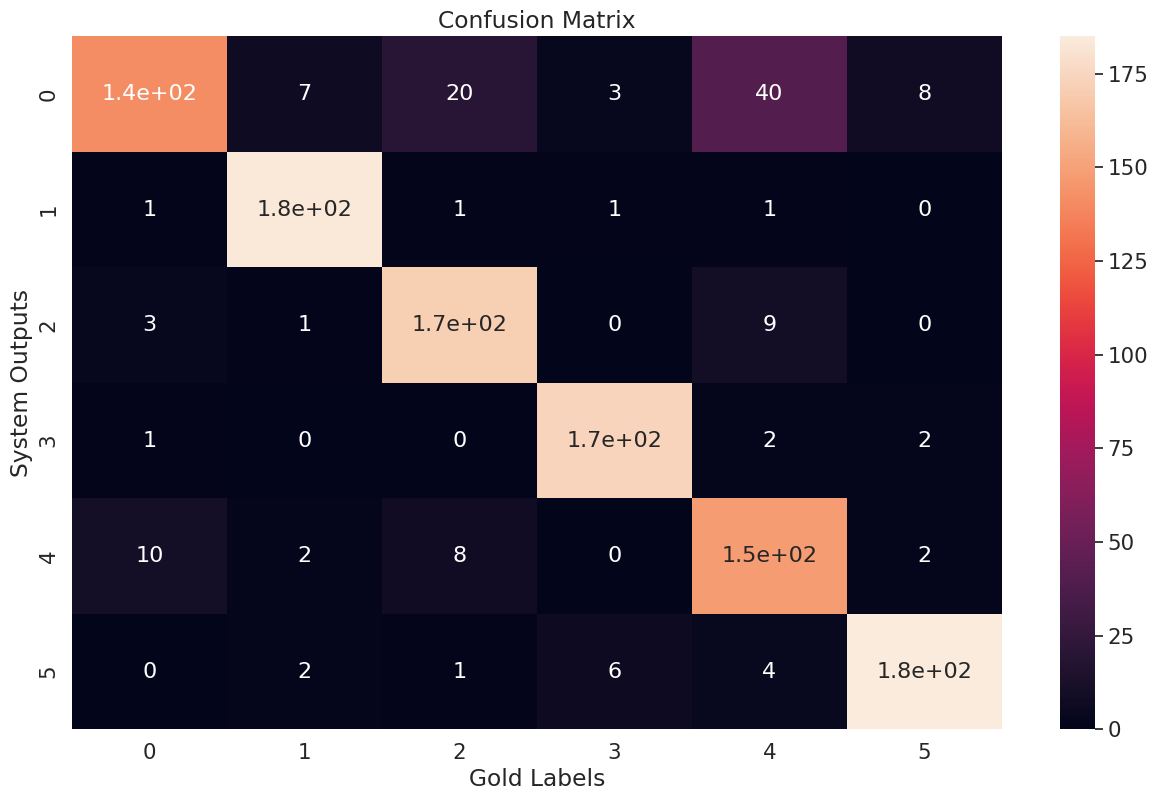

Classification Accuracy:  0.8812664907651715
Macro-Average F1:  0.880876211422508
Macro-Average Precision:  0.8838804375620213
Macro-Average Recall:  0.8881319628229098


In [64]:
# printing everything
cm = pd.DataFrame(cm, range(0, numClasses), range(0, numClasses))
plt.figure(figsize=(15,9))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16})
plt.xlabel("Gold Labels")
plt.ylabel("System Outputs")
plt.title("Confusion Matrix")
plt.show()

print("Classification Accuracy: ", accuracy)
print("Macro-Average F1: ", report["macro avg"]["f1-score"])
print("Macro-Average Precision: ", report["macro avg"]["precision"])
print("Macro-Average Recall: ", report["macro avg"]["recall"])

#### Using Embeddings

Making the training set

In [69]:
train = pd.read_csv("./train_embeddings_data.csv")
train_features = train["embeddings"]
train_labels = train["Twitter Handle"]

num_arr = [0, 1, 2, 3, 4, 5]
numeric_labels_dict = dict(zip(twitter_handles, num_arr))
m = 5
numClasses = 6 
accuracies = []
f1s = []


def make_numeric_labels(train_labels, numeric_labels_dict):
    result = []
    for ind in train_labels.index:
        result.append(numeric_labels_dict[train_labels[ind]])
    return result

def make_numeric_features(train_features):
    result = []
    for ind in train_features.index:
        features = train_features[ind].split()
        features[0] = features[0].replace("[", "")
        features[-1] = features[-1].replace("]", "")
        while '' in features:
            features.remove('')
        for i in range(len(features)):
            features[i] = float(features[i])
        result.append(features) 
    return result       


train_Y = make_numeric_labels(train_labels, numeric_labels_dict)
train_X = make_numeric_features(train_features)
train_X = np.array(train_X)
train_Y = np.array(train_Y)

Making test set

In [70]:
test = pd.read_csv("./test_embeddings_data.csv")
test_features = test["embeddings"]
test_labels = test["Twitter Handle"]

num_arr = [0, 1, 2, 3, 4, 5]
numeric_labels_dict = dict(zip(twitter_handles, num_arr))
m = 5
numClasses = 6 
accuracies = []
f1s = []


def make_numeric_labels(test_labels, numeric_labels_dict):
    result = []
    for ind in test_labels.index:
        result.append(numeric_labels_dict[test_labels[ind]])
    return result

def make_numeric_features(test_features):
    result = []
    for ind in test_features.index:
        features = test_features[ind].split()
        features[0] = features[0].replace("[", "")
        features[-1] = features[-1].replace("]", "")
        while '' in features:
            features.remove('')
        for i in range(len(features)):
            features[i] = float(features[i])
        result.append(features) 
    return result       

test_Y = make_numeric_labels(test_labels, numeric_labels_dict)
test_X = make_numeric_features(test_features)
test_X = np.array(test_X)
test_Y = np.array(test_Y)

Fitting the model and testing on test set

In [73]:
cart = BaggingClassifier(KNeighborsClassifier(), max_samples=0.95, max_features=0.95)
cart.fit(train_X, train_Y)
cart.fit(train_X, train_Y)
predictEx = cart.predict(test_X)
accuracy = accuracy_score(predictEx, test_Y)
report = classification_report(predictEx, test_Y, output_dict=True)
cm = confusion_matrix(predictEx,test_Y)

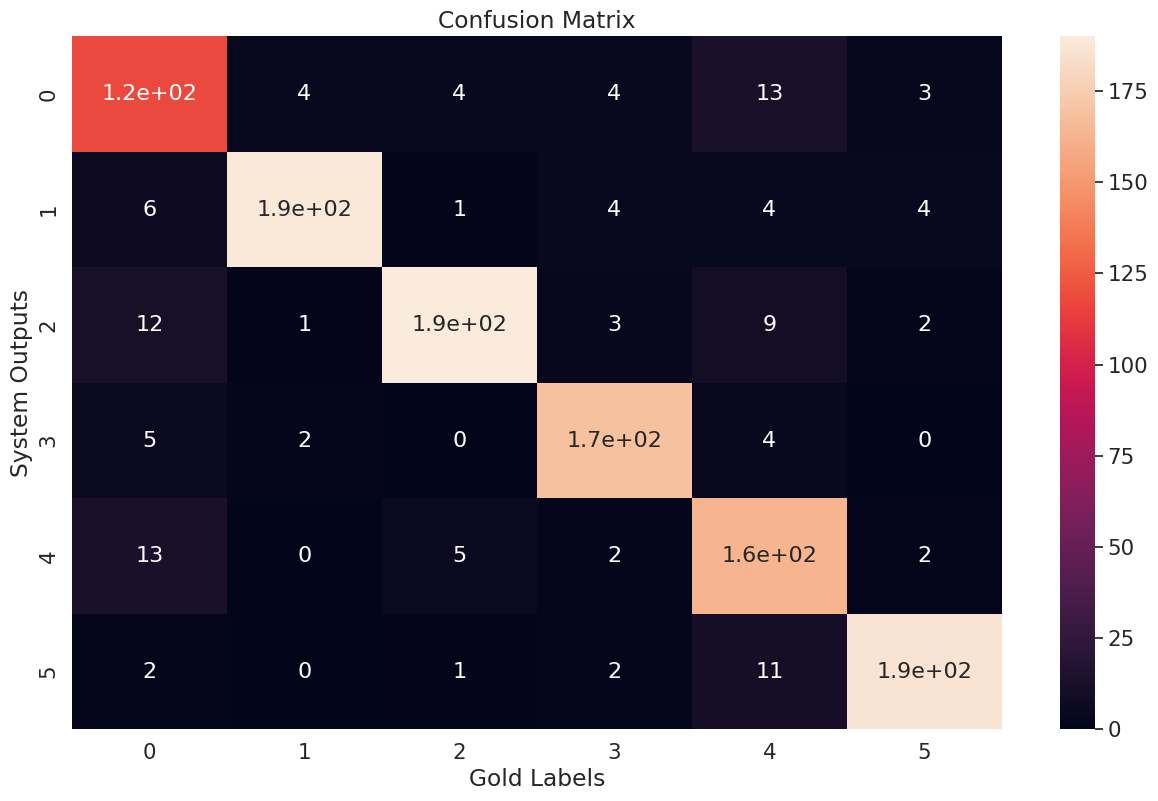

Classification Accuracy:  0.8918205804749341
Macro-Average F1:  0.8874699623250901
Macro-Average Precision:  0.8879077929357572
Macro-Average Recall:  0.8887949707521526


In [74]:
# printing everything
cm = pd.DataFrame(cm, range(0, numClasses), range(0, numClasses))
plt.figure(figsize=(15,9))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16})
plt.xlabel("Gold Labels")
plt.ylabel("System Outputs")
plt.title("Confusion Matrix")
plt.show()

print("Classification Accuracy: ", accuracy)
print("Macro-Average F1: ", report["macro avg"]["f1-score"])
print("Macro-Average Precision: ", report["macro avg"]["precision"])
print("Macro-Average Recall: ", report["macro avg"]["recall"])

# Theoretical Understanding

### Q1: Which model performed best and why do you think that is?
Ensemble Methods. Highest accuracy and f1 scores. 
 - KNNs arent good because of the very high dimensionality
 - Training NNs was very expensive in terms of computation time taken
 - NNs may have overfitted to the training data even after cross validation so the variance of the models is higher.
 - Ensemble methods gave great results in a small time 
 
### Q2: Which features gave better results for each model? Explain.
For each model, we got better results with embeddings than BOWs.
Embeddings encode the meaning of the sentence as well and take in the context, unlike BOWs that just rely on the frequencies of each word in the BOW.

### Q3: What effect would increasing the classes to 150 have?
In short- increasing the number of classes while keeping the size of the dataset the same would lead to a drop in accuracy of predicted labels i.e the accuracy of a classification model will inversely change with the number of classes in the dataset. The larger number of classes causes a smaller difference in probabilities between them thus it becomes difficult for the model to accurately identify them. Moreover, due to the nature of text attribution and the distinct nature of tweets, an imbalance of data will most likely cause a bias towards the majority class.


### Q4: Suggest improvements to text preparation, feature extraction, and models that can be made to perform this task better.
Text Prep:
Use a bigger stop_words dataset.
Should not have removed hashtags and @twitter_handles from the dataset as they can be used as unique identifiers for each handle.
Text prep is not consistent in each handle, it should be consistent for an increased performance.

Feature Extraction:
Use numpy arrays instead of pandaframe while creating BOWs.
Use builtin scikit learn’s function to create the bag_of_words instead of creating it manually for optimization.
 
KNNs:
Try using the KNN model with Manhattan distance for a possibly higher accuracy.
Perform higher k fold cross validation for a better trained model.

NNs:
Use pytorch/tensorflow for the classification model. They allow the user to tweak the model more according to the dataset’s needs.
Use a deeper neural network.
Perform higher k fold cross validation.

Ensemble:
Use stacking or boosting to possibly increase the accuracy of the model.
### Q5: What - in your understanding - are the applications of authorship attribution?
The applications of authorship attribution are various. For example, it can closely identify borderline plagiarism, that is, copying another author’s writing style. It can also be used to identify harmful messages, for example messages sent to each other by known terrorists. It can be used in criminal law, civil law, and computer security as well, in order to track down the authors of a computer virus using source code. It can be used in appliances used for identification such as biometrics, cryptographic signatures, and intrusion detection systems. It can also be used to identify language specific features.